In [1]:
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from datetime import timedelta
from polygon import RESTClient
import requests
from pandas.tseries.offsets import BDay

### 1. Collect data for the last 14 years - from 2010 to 2023 in daily granularity.
### 2. Identify top 10 outliers in each year.

In [2]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
pair = "C:USDCHF"
years = range(2010, 2024)

# Initialize DataFrames
stats_data = pd.DataFrame(columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each year
for year in years:
	# Format the API endpoint
	start_date = f'{year}-01-01'
	end_date = f'{year}-12-31'
	url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
	
	# Make the API request
	response = requests.get(url)
	data = response.json()
	
	# Check if the request was successful
	if response.status_code == 200 and 'results' in data:
		# Load data into a DataFrame
		df = pd.DataFrame(data['results'])
        # Converting timestamps
		df['date'] = pd.to_datetime(df['t'], unit='ms')
		df.drop(columns=['t'], inplace=True)
        # Calculating returns
		df = calculate_daily_returns(df)
        
		# Calculate basic statistical properties of the daily returns
		returns = df['daily_return'] 
		mean_return = returns.mean()
		variance_return = returns.var()
		skewness_return = skew(returns)
		kurtosis_return = kurtosis(returns)

		# Collect stats data by year
		year_stats = pd.DataFrame([[year, mean_return, variance_return, skewness_return, kurtosis_return]],
									columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
		stats_data = pd.concat([stats_data, year_stats], ignore_index=True)

		# Append the data to the full_data DataFrame for the current currency pair
		df['year'] = year
		full_data = pd.concat([full_data, df], ignore_index=True)

		# Find the top 10 outliers based on absolute values of the daily return value
		df['abs_daily_return'] = df['c'].abs()
		outliers = df.nlargest(10, 'abs_daily_return')

		# Append outliers to the outliers_data DataFrame for the current currency pair
		outliers['year'] = year
		outliers_data = pd.concat([outliers_data, outliers], ignore_index=True)

# Sort the data by date so that visualization could be done in a better way         
sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_47040/3047513548.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_data = pd.concat([stats_data, year_stats], ignore_index=True)


In [3]:
sorted_full_data

v      vw         o         c         h         l       n  \
0       2359  1.0351  1.036260  1.036040  1.036880  1.033780    2359   
1      69913  1.0329  1.036060  1.028910  1.041960  1.026210   69913   
2      76822  1.0304  1.029000  1.033410  1.035960  1.025150   76822   
3      81057  1.0321  1.033410  1.027460  1.037830  1.024800   81057   
4      72488  1.0321  1.027440  1.033700  1.037050  1.024140   72488   
...      ...     ...       ...       ...       ...       ...     ...   
4449  112192  0.8555  0.856000  0.853720  0.857960  0.852800  112192   
4450  174820  0.8495  0.853590  0.842500  0.854870  0.840600  174820   
4451  196178  0.8392  0.842400  0.843370  0.845145  0.833000  196178   
4452  214081  0.8403  0.843460  0.840710  0.843560  0.835400  214081   
4453       1  0.8408  0.840759  0.840759  0.840759  0.840759       1   

           date  prev_close  daily_return  abs_daily_return  year  
0    2010-01-03         NaN           NaN               NaN  2010  
1    2010-01-04     1.03604     -0.006882          0.006882  2010  
2    2010-01-05     1.02891      0.004374          0.004374  2010  
3    2010-01-06     1.03341     -0.005758          0.005758  2010  
4    2010-01-07     1.02746      0.006073          0.006073  2010  
...         ...         ...           ...               ...   ...  
4449 2023-12-26     0.85581     -0.002442          0.002442  2023  
4450 2023-12-27     0.85372     -0.013142          0.013142  2023  
4451 2023-12-28     0.84250      0.001033          0.001033  2023  
4452 2023-12-29     0.84337     -0.003154          0.003154  2023  
4453 2023-12-31     0.84071      0.000059          0.000059  2023  

[4454 rows x 12 columns]

In [4]:
sorted_outliers_data

v      vw        o        c        h        l       n       date  \
3    116306  1.1565  1.15104  1.16024  1.16191  1.14913  116306 2010-05-24   
7    176660  1.1625  1.16023  1.15739  1.16950  1.15178  176660 2010-05-25   
5    135028  1.1579  1.15739  1.15873  1.16230  1.15139  135028 2010-05-26   
4    103597  1.1541  1.15223  1.15927  1.15929  1.14801  103597 2010-05-28   
6      4795  1.1580  1.15828  1.15740  1.15920  1.15709    4795 2010-05-30   
..      ...     ...      ...      ...      ...      ...     ...        ...   
137  168297  0.9389  0.94201  0.93949  0.94290  0.93480  168297 2023-03-01   
132  164385  0.9419  0.93950  0.94180  0.94400  0.93890  164385 2023-03-02   
138    2794  0.9366  0.93590  0.93680  0.93698  0.93550    2794 2023-03-05   
130  172706  0.9356  0.93069  0.94223  0.94260  0.92830  172706 2023-03-07   
133  154890  0.9418  0.94223  0.94085  0.94384  0.93879  154890 2023-03-08   

     prev_close  daily_return  abs_daily_return  year  
3      1.151030      0.008002           1.16024  2010  
7      1.160240     -0.002456           1.15739  2010  
5      1.157390      0.001158           1.15873  2010  
4      1.152140      0.006188           1.15927  2010  
6      1.159270     -0.001613           1.15740  2010  
..          ...           ...               ...   ...  
137    0.941868     -0.002524           0.93949  2023  
132    0.939490      0.002459           0.94180  2023  
138    0.935854      0.001011           0.93680  2023  
130    0.930550      0.012552           0.94223  2023  
133    0.942230     -0.001465           0.94085  2023  

[140 rows x 12 columns]

In [5]:
stats_data

Year      Mean  Variance  Skewness  Kurtosis
0   2010 -0.000314  0.000038       NaN       NaN
1   2011  0.000070  0.000097       NaN       NaN
2   2012 -0.000074  0.000024       NaN       NaN
3   2013 -0.000060  0.000028       NaN       NaN
4   2014  0.000349  0.000015       NaN       NaN
5   2015  0.000075  0.000128       NaN       NaN
6   2016  0.000067  0.000020       NaN       NaN
7   2017 -0.000133  0.000015       NaN       NaN
8   2018  0.000036  0.000013       NaN       NaN
9   2019 -0.000068  0.000010       NaN       NaN
10  2020 -0.000289  0.000017       NaN       NaN
11  2021  0.000111  0.000016       NaN       NaN
12  2022  0.000050  0.000025       NaN       NaN
13  2023 -0.000252  0.000018       NaN       NaN

Skewness and Kurtosis (NaN): The NaN values likely indicate that daily returns for many years are very close to zero with little variance, thus not allowing for a meaningful calculation of skewness and kurtosis. This could mean the market is highly stable on a day-to-day basis, with changes being very subtle.

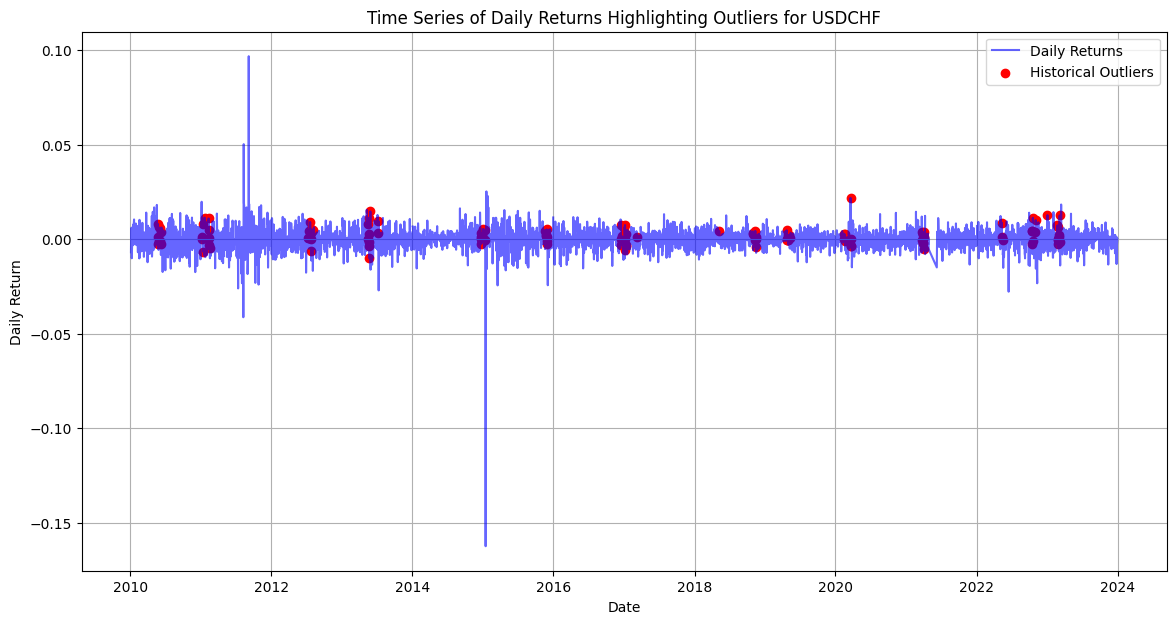

In [6]:
def plot_data_with_outliers(full_data, outliers_data):
    plt.figure(figsize=(14, 7))
    plt.plot(full_data['date'], full_data['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(outliers_data['date'], outliers_data['daily_return'], color='red', label='Historical Outliers')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDCHF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(sorted_full_data, outliers_data)

### 3. Collect data of 3 days prior and post for each of these outliers in hourly granularity.

In [6]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - BDay(3),
    "end_date": sorted_outliers_data['date'] + BDay(3),
    "outlier_date": sorted_outliers_data['date'],
    "year": sorted_outliers_data['year']
})

date_ranges

start_date   end_date outlier_date  year
3   2010-05-19 2010-05-27   2010-05-24  2010
7   2010-05-20 2010-05-28   2010-05-25  2010
5   2010-05-21 2010-05-31   2010-05-26  2010
4   2010-05-25 2010-06-02   2010-05-28  2010
6   2010-05-26 2010-06-02   2010-05-30  2010
..         ...        ...          ...   ...
137 2023-02-24 2023-03-06   2023-03-01  2023
132 2023-02-27 2023-03-07   2023-03-02  2023
138 2023-03-01 2023-03-08   2023-03-05  2023
130 2023-03-02 2023-03-10   2023-03-07  2023
133 2023-03-03 2023-03-13   2023-03-08  2023

[140 rows x 4 columns]

In [140]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df


def fetch_hourly_data_chunk(pair, start_date, end_date, api_key):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None

    response_data = response.json()

    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], units='ms')
    df.drop(columns=['t'], inplace=True)
                                
    return df                            

def fetch_and_process_hourly_data(pair, start_date, end_date, api_key):

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    chunk_size = 7
    date_ranges = [(start_date + timedelta(days=i*chunk_size), 
                    min(end_date, start_date + timedelta(days=(i+1)*chunk_size - 1)))
                   for i in range((end_date - start_date).days // chunk_size + 1)]

    all_data = []

    for start, end in date_ranges:
        chunk_data = fetch_hourly_data_chunk(pair, start, end, api_key)
        if chunk_data is not None:
            all_data.append(chunk_data)
    
    if not all_data:
        print("No data fetched")
        return None
    
    df = pd.concat(all_data)

    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)
    print(hourly_data)
    
    # Create full index from start_date to end_date at hourly frequency
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')

    # Reindex hourly_data using the full index, filling missing rows with NaN
    hourly_data = hourly_data.reindex(full_index)
    # print(hourly_data)
    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)

    return hourly_data

     # client = RESTClient(api_key)
    # response = client.get_aggs(
    #     ticker = pair,
    #     multiplier = 1,
    #     timespan = 'hour',
    #     from_ = start_date,
    #     to = end_date
    # )

    # if response:
    #     df = pd.DataFrame(response)

    #     df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    #     # print(df)
    #     df.drop(columns=['timestamp'], inplace=True)
    
    #     hourly_data = calculate_daily_returns(df)
        
        
    #     hourly_data.set_index('date', inplace=True)
    #     print(hourly_data)
        
    #     # Create full index from start_date to end_date at hourly frequency
    #     full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
    
    #     # Reindex hourly_data using the full index, filling missing rows with NaN
    #     hourly_data = hourly_data.reindex(full_index)
    #     # print(hourly_data)
    #     hourly_data.reset_index(inplace=True)
    #     hourly_data.rename(columns={'index': 'date'}, inplace=True)
    
    #     return hourly_data

In [162]:
import pandas as pd
import requests
from datetime import datetime, timedelta

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df

def fetch_hourly_data_chunk(symbol, start_date, end_date, api_key):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None
    
    response_data = response.json()
    
    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    
    return df

def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    # Split the date range into smaller chunks
    chunk_size = 3  # Fetch data in 7-day chunks
    date_ranges = [(start_date + timedelta(days=i*chunk_size), 
                    min(end_date, start_date + timedelta(days=(i+1)*chunk_size - 1)))
                   for i in range((end_date - start_date).days // chunk_size + 1)]

    # print((end_date - start_date).days // chunk_size + 1)
    all_data = []

    for start, end in date_ranges:
        chunk_data = fetch_hourly_data_chunk(symbol, start, end, api_key)
        if chunk_data is not None:
            all_data.append(chunk_data)
    
    if not all_data:
        print("No data fetched")
        return None
    
    df = pd.concat(all_data)
    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)
    
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
    hourly_data = hourly_data.reindex(full_index)
    
    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)
    
    return hourly_data

# Example usage
# symbol = "AAPL"
# start_date = datetime(2010, 5, 24)
# end_date = datetime(2010, 5, 30)
# api_key = "YOUR_API_KEY"
# data = fetch_and_process_hourly_data(symbol, start_date, end_date, api_key)


In [37]:
# # Initialize empty DataFrame
# all_data = pd.DataFrame()

# # Initialize an outlier identifier starting from 1 or any specific number
# outlier_id = 1

# for index, row in date_ranges.iterrows():
#     # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
#     start_date_ts = pd.Timestamp(row['start_date'])
#     end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
#     outlier_date_ts = pd.Timestamp(row['outlier_date'])

#     # #Calculate the prior 3 business days
#     # prior_start_date_ts = outlier_date_ts - BDay(3)

#     # #Calculate the post 3 business days
#     # post_end_date_ts = outlier_date_ts + BDay(3)
    
#     # Get hourly data for the range including 3 days before and after the outlier
#     hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)

#     # Check if hourly_data is not None before processing
#     if hourly_data is not None:
#         # Assign the current outlier_id to the data
#         hourly_data['outlier_id'] = outlier_id

#         # Filter out weekdends
#         hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]

#         # prior_data from start_date to outlier_date inclusive
#         prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
#         prior_data["day type"] = "prior day"

#         # outlier_data is for the hourly data on the day of the outlier
#         outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
#         outlier_data["day type"] = "outlier day"

#         # post_data from the day after outlier_date to end_date
#         post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
#         post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] <= end_date_ts)]
#         post_data["day type"] = "post day"

#         # Concatenate the data from this iteration to the cumulative DataFrame
#         all_data = pd.concat([all_data, prior_data, outlier_data, post_data])

#         # Increment the outlier_id for the next iteration
#         outlier_id += 1

#     else:
#         print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# # Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
# all_data.reset_index(drop=True, inplace=True)

In [167]:
# Initialize empty DataFrame
all_data1 = pd.DataFrame()

# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1


for index, row in date_ranges.iterrows():
    # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
    start_date_ts = pd.Timestamp(row['start_date'])
    end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
    outlier_date_ts = pd.Timestamp(row['outlier_date'])
    
    # Get hourly data for the range including 3 days before and after the outlier
    hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)
    print(hourly_data)
    # Check if hourly_data is not None before processing
    if hourly_data is not None:
        # Assign the current outlier_id to the data
        hourly_data['outlier_id'] = outlier_id

        # Filter out weekdends
        hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]
        
        # prior_data from start_date to outlier_date inclusive
        prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
        prior_data["day type"] = "prior day"

        # outlier_data is for the hourly data on the day of the outlier
        outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
        outlier_data["day type"] = "outlier day"

        # post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] < end_date_ts)]
        # post_data["day type"] = "post day"
        
        # post_data from the day after outlier_date to end_date
        post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
        post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] <= end_date_ts)]
        post_data["day type"] = "post day"
        print(post_outlier_ts)
        print(end_date_ts)
        print(post_data)
        
        # Concatenate the data from this iteration to the cumulative DataFrame
        all_data1 = pd.concat([all_data1, prior_data, outlier_data, post_data])

        # Increment the outlier_id for the next iteration
        outlier_id += 1

    else:
        print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# Add the day column to the final DataFrame
all_data1['day'] = all_data1['date'].dt.day_name()
# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data1.reset_index(drop=True, inplace=True)

                   date        v      vw        o        c        h        l  \
0   2010-05-19 00:00:00   9373.0  1.1507  1.15299  1.15113  1.15302  1.14899   
1   2010-05-19 01:00:00   6584.0  1.1502  1.15114  1.14938  1.15219  1.14846   
2   2010-05-19 02:00:00   4968.0  1.1489  1.14939  1.14758  1.14972  1.14758   
3   2010-05-19 03:00:00   6480.0  1.1476  1.14753  1.14893  1.14959  1.14648   
4   2010-05-19 04:00:00   4950.0  1.1487  1.14893  1.14875  1.14981  1.14776   
5   2010-05-19 05:00:00   6427.0  1.1478  1.14873  1.14844  1.14935  1.14643   
6   2010-05-19 06:00:00  11241.0  1.1490  1.14842  1.14680  1.15144  1.14670   
7   2010-05-19 07:00:00  17967.0  1.1482  1.14681  1.14834  1.15286  1.14514   
8   2010-05-19 08:00:00  13049.0  1.1503  1.14834  1.15000  1.15203  1.14814   
9   2010-05-19 09:00:00   9866.0  1.1495  1.15000  1.14954  1.15096  1.14824   
10  2010-05-19 10:00:00   8652.0  1.1495  1.14954  1.14965  1.15117  1.14824   
11  2010-05-19 11:00:00  13586.0  1.1479

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'b4cf6da3e4bd145f36f07ce05fdf4a68'}
                   date        v      vw        o        c        h        l  \
0   2010-05-20 00:00:00   4679.0  1.1535  1.15235  1.15393  1.15445  1.15217   
1   2010-05-20 01:00:00   6817.0  1.1541  1.15392  1.15525  1.15575  1.15297   
2   2010-05-20 02:00:00   3104.0  1.1545  1.15525  1.15349  1.15554  1.15342   
3   2010-05-20 03:00:00   2978.0  1.1526  1.15341  1.15203  1.15406  1.15158   
4   2010-05-20 04:00:00   3201.0  1.1523  1.15204  1.15275  1.15280  1.15147   
5   2010-05-20 05:00:00   9024.0  1.1537  1.15275  1.15655  1.15718  1.15203   
6   2010-05-20 06:00:00   8984.0  1.1541  1.15658  1.15038  1.15736  1.14955   
7   2010-05-20 07:00:00  12605.0  1.1506  1.15035  1.14887  1.15448  1.14734   
8   2010-05-20 08:00:00   9775.0  1.1494  1.14885  1.14871  1.15162  1.14730   
9   2010-05-20 09:00:00   8977.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2010-05-21 00:00:00   7789.0  1.1496  1.14874  1.14920  1.15096  1.14803   
1   2010-05-21 01:00:00   5850.0  1.1500  1.14920  1.15099  1.15252  1.14815   
2   2010-05-21 02:00:00   6241.0  1.1526  1.15103  1.15387  1.15737  1.15017   
3   2010-05-21 03:00:00   4263.0  1.1550  1.15392  1.15403  1.15797  1.15303   
4   2010-05-21 04:00:00   7278.0  1.1522  1.15399  1.15319  1.15433  1.14992   
5   2010-05-21 05:00:00   6276.0  1.1519  1.15321  1.14859  1.15593  1.14818   
6   2010-05-21 06:00:00   9714.0  1.1492  1.14852  1.14549  1.15211  1.14496   
7   2010-05-21 07:00:00   9169.0  1.1499  1.14551  1.15039  1.15143  1.14539   
8   2010-05-21 08:00:00  10825.0  1.1504  1.15037  1.15180  1.15192  1.14876   
9   2010-05-21 09:00:00   9345.0  1.1494  1.15182  1.14940  1.15193  1.14717   
10  2010-05-21 10:00:00   6854.0  1.1489  1.14940  1.15004  1.15056  1.14675   
11  2010-05-21 11:00:00   7479.0  1.1501

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2010-05-25 00:00:00   5809.0  1.1605  1.16023  1.16038  1.16175  1.15914   
1   2010-05-25 01:00:00   6172.0  1.1606  1.16040  1.16058  1.16202  1.15969   
2   2010-05-25 02:00:00   4848.0  1.1608  1.16061  1.16090  1.16201  1.16005   
3   2010-05-25 03:00:00   3040.0  1.1609  1.16094  1.16092  1.16173  1.15988   
4   2010-05-25 04:00:00   2161.0  1.1608  1.16093  1.16090  1.16154  1.16017   
5   2010-05-25 05:00:00   3572.0  1.1612  1.16096  1.16124  1.16184  1.16018   
6   2010-05-25 06:00:00  11133.0  1.1603  1.16124  1.15905  1.16219  1.15815   
7   2010-05-25 07:00:00  13203.0  1.1614  1.15905  1.16309  1.16425  1.15861   
8   2010-05-25 08:00:00  10406.0  1.1639  1.16309  1.16441  1.16560  1.16275   
9   2010-05-25 09:00:00   9408.0  1.1664  1.16437  1.16813  1.16835  1.16410   
10  2010-05-25 10:00:00   9459.0  1.1683  1.16816  1.16745  1.16950  1.16690   
11  2010-05-25 11:00:00   8063.0  1.1675

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2010-05-26 00:00:00   5095.0  1.1577  1.15739  1.15791  1.15867  1.15618   
1   2010-05-26 01:00:00   6732.0  1.1595  1.15794  1.16020  1.16103  1.15741   
2   2010-05-26 02:00:00   3196.0  1.1597  1.16020  1.15950  1.16093  1.15872   
3   2010-05-26 03:00:00   2506.0  1.1609  1.15953  1.16148  1.16168  1.15935   
4   2010-05-26 04:00:00   3212.0  1.1608  1.16146  1.16055  1.16161  1.16011   
5   2010-05-26 05:00:00   4029.0  1.1613  1.16056  1.16191  1.16230  1.16038   
6   2010-05-26 06:00:00   4797.0  1.1611  1.16191  1.16115  1.16212  1.16030   
7   2010-05-26 07:00:00   6715.0  1.1603  1.16116  1.15908  1.16184  1.15879   
8   2010-05-26 08:00:00   9272.0  1.1564  1.15907  1.15485  1.15928  1.15386   
9   2010-05-26 09:00:00   6096.0  1.1540  1.15485  1.15345  1.15571  1.15256   
10  2010-05-26 10:00:00   6577.0  1.1532  1.15346  1.15205  1.15493  1.15185   
11  2010-05-26 11:00:00   5454.0  1.1523

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2010-05-26 00:00:00   5095.0  1.1577  1.15739  1.15791  1.15867  1.15618   
1   2010-05-26 01:00:00   6732.0  1.1595  1.15794  1.16020  1.16103  1.15741   
2   2010-05-26 02:00:00   3196.0  1.1597  1.16020  1.15950  1.16093  1.15872   
3   2010-05-26 03:00:00   2506.0  1.1609  1.15953  1.16148  1.16168  1.15935   
4   2010-05-26 04:00:00   3212.0  1.1608  1.16146  1.16055  1.16161  1.16011   
5   2010-05-26 05:00:00   4029.0  1.1613  1.16056  1.16191  1.16230  1.16038   
6   2010-05-26 06:00:00   4797.0  1.1611  1.16191  1.16115  1.16212  1.16030   
7   2010-05-26 07:00:00   6715.0  1.1603  1.16116  1.15908  1.16184  1.15879   
8   2010-05-26 08:00:00   9272.0  1.1564  1.15907  1.15485  1.15928  1.15386   
9   2010-05-26 09:00:00   6096.0  1.1540  1.15485  1.15345  1.15571  1.15256   
10  2010-05-26 10:00:00   6577.0  1.1532  1.15346  1.15205  1.15493  1.15185   
11  2010-05-26 11:00:00   5454.0  1.1523

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '352d91b178110c831036779a37e389e0'}
                   date        v      vw        o        c        h        l  \
0   2010-05-27 00:00:00   3760.0  1.1585  1.15875  1.15756  1.15933  1.15725   
1   2010-05-27 01:00:00   3265.0  1.1571  1.15758  1.15820  1.15845  1.15637   
2   2010-05-27 02:00:00   4251.0  1.1577  1.15820  1.15670  1.15854  1.15640   
3   2010-05-27 03:00:00   3091.0  1.1564  1.15673  1.15640  1.15701  1.15579   
4   2010-05-27 04:00:00   5309.0  1.1544  1.15626  1.15365  1.15661  1.15275   
5   2010-05-27 05:00:00   5689.0  1.1544  1.15368  1.15314  1.15709  1.15309   
6   2010-05-27 06:00:00   6669.0  1.1532  1.15316  1.15236  1.15478  1.15215   
7   2010-05-27 07:00:00   8819.0  1.1537  1.15238  1.15579  1.15612  1.15115   
8   2010-05-27 08:00:00   6071.0  1.1555  1.15581  1.15529  1.15652  1.15446   
9   2010-05-27 09:00:00   6483.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2010-06-01 00:00:00   4575.0  1.1562  1.15577  1.15615  1.15714  1.15547   
1   2010-06-01 01:00:00   4625.0  1.1559  1.15614  1.15630  1.15688  1.15505   
2   2010-06-01 02:00:00   3645.0  1.1564  1.15630  1.15665  1.15705  1.15532   
3   2010-06-01 03:00:00   2762.0  1.1556  1.15663  1.15590  1.15666  1.15480   
4   2010-06-01 04:00:00   4342.0  1.1549  1.15590  1.15638  1.15682  1.15365   
5   2010-06-01 05:00:00   5367.0  1.1549  1.15638  1.15373  1.15650  1.15219   
6   2010-06-01 06:00:00   6079.0  1.1553  1.15373  1.15709  1.15794  1.15281   
7   2010-06-01 07:00:00   9531.0  1.1609  1.15709  1.16252  1.16421  1.15701   
8   2010-06-01 08:00:00   9615.0  1.1653  1.16250  1.16860  1.16889  1.16231   
9   2010-06-01 09:00:00   9293.0  1.1696  1.16862  1.17046  1.17075  1.16784   
10  2010-06-01 10:00:00   8146.0  1.1711  1.17046  1.17044  1.17302  1.16971   
11  2010-06-01 11:00:00  11137.0  1.1673

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2010-06-02 00:00:00   4513.0  1.1562  1.15475  1.15472  1.15760  1.15461   
1   2010-06-02 01:00:00   4605.0  1.1549  1.15472  1.15514  1.15580  1.15395   
2   2010-06-02 02:00:00   2206.0  1.1551  1.15509  1.15460  1.15624  1.15401   
3   2010-06-02 03:00:00   4188.0  1.1563  1.15461  1.15700  1.15780  1.15461   
4   2010-06-02 04:00:00   4560.0  1.1580  1.15696  1.15722  1.15885  1.15668   
5   2010-06-02 05:00:00   4437.0  1.1577  1.15722  1.15722  1.15875  1.15613   
6   2010-06-02 06:00:00   5948.0  1.1575  1.15720  1.15558  1.15871  1.15531   
7   2010-06-02 07:00:00   7247.0  1.1555  1.15558  1.15555  1.15785  1.15343   
8   2010-06-02 08:00:00   5748.0  1.1557  1.15550  1.15597  1.15678  1.15454   
9   2010-06-02 09:00:00   4645.0  1.1545  1.15593  1.15336  1.15615  1.15266   
10  2010-06-02 10:00:00   7124.0  1.1553  1.15341  1.15638  1.15745  1.15269   
11  2010-06-02 11:00:00   8023.0  1.1577

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2010-06-02 00:00:00   4513.0  1.1562  1.15475  1.15472  1.15760  1.15461   
1   2010-06-02 01:00:00   4605.0  1.1549  1.15472  1.15514  1.15580  1.15395   
2   2010-06-02 02:00:00   2206.0  1.1551  1.15509  1.15460  1.15624  1.15401   
3   2010-06-02 03:00:00   4188.0  1.1563  1.15461  1.15700  1.15780  1.15461   
4   2010-06-02 04:00:00   4560.0  1.1580  1.15696  1.15722  1.15885  1.15668   
5   2010-06-02 05:00:00   4437.0  1.1577  1.15722  1.15722  1.15875  1.15613   
6   2010-06-02 06:00:00   5948.0  1.1575  1.15720  1.15558  1.15871  1.15531   
7   2010-06-02 07:00:00   7247.0  1.1555  1.15558  1.15555  1.15785  1.15343   
8   2010-06-02 08:00:00   5748.0  1.1557  1.15550  1.15597  1.15678  1.15454   
9   2010-06-02 09:00:00   4645.0  1.1545  1.15593  1.15336  1.15615  1.15266   
10  2010-06-02 10:00:00   7124.0  1.1553  1.15341  1.15638  1.15745  1.15269   
11  2010-06-02 11:00:00   8023.0  1.1577

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-01-04 00:00:00   4340.0  0.9336  0.93411  0.93410  0.93455  0.93252   
1   2011-01-04 01:00:00   2898.0  0.9347  0.93409  0.93535  0.93554  0.93385   
2   2011-01-04 02:00:00   2507.0  0.9352  0.93536  0.93491  0.93564  0.93458   
3   2011-01-04 03:00:00   2751.0  0.9348  0.93492  0.93517  0.93530  0.93409   
4   2011-01-04 04:00:00   3399.0  0.9355  0.93518  0.93579  0.93585  0.93494   
5   2011-01-04 05:00:00   4061.0  0.9363  0.93581  0.93679  0.93728  0.93523   
6   2011-01-04 06:00:00   5168.0  0.9376  0.93676  0.93708  0.93901  0.93664   
7   2011-01-04 07:00:00   6871.0  0.9383  0.93708  0.93935  0.93970  0.93651   
8   2011-01-04 08:00:00   9081.0  0.9418  0.93935  0.94217  0.94451  0.93935   
9   2011-01-04 09:00:00   8430.0  0.9422  0.94218  0.94205  0.94345  0.94093   
10  2011-01-04 10:00:00   7183.0  0.9429  0.94205  0.94409  0.94444  0.94129   
11  2011-01-04 11:00:00   7020.0  0.9449

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-01-05 00:00:00   4983.0  0.9478  0.94712  0.94761  0.94851  0.94676   
1   2011-01-05 01:00:00   4343.0  0.9484  0.94761  0.94838  0.94908  0.94750   
2   2011-01-05 02:00:00   2655.0  0.9484  0.94838  0.94867  0.94874  0.94781   
3   2011-01-05 03:00:00   1856.0  0.9489  0.94867  0.94924  0.94929  0.94848   
4   2011-01-05 04:00:00   2665.0  0.9492  0.94925  0.94913  0.94966  0.94880   
5   2011-01-05 05:00:00   5106.0  0.9498  0.94916  0.95003  0.95173  0.94838   
6   2011-01-05 06:00:00   5025.0  0.9495  0.95003  0.94974  0.95025  0.94882   
7   2011-01-05 07:00:00   5912.0  0.9497  0.94975  0.95131  0.95137  0.94860   
8   2011-01-05 08:00:00   8995.0  0.9507  0.95135  0.95021  0.95228  0.94980   
9   2011-01-05 09:00:00   6929.0  0.9505  0.95021  0.95117  0.95145  0.94945   
10  2011-01-05 10:00:00   8063.0  0.9510  0.95118  0.95129  0.95226  0.94985   
11  2011-01-05 11:00:00   7623.0  0.9515

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '322841cc38c3ee256b50bb6f05be7a67'}
                   date        v      vw        o        c        h        l  \
0   2011-01-06 00:00:00   5102.0  0.9663  0.96584  0.96716  0.96722  0.96545   
1   2011-01-06 01:00:00   3497.0  0.9667  0.96717  0.96642  0.96748  0.96613   
2   2011-01-06 02:00:00   4206.0  0.9672  0.96643  0.96821  0.96834  0.96604   
3   2011-01-06 03:00:00   3762.0  0.9678  0.96820  0.96691  0.96828  0.96691   
4   2011-01-06 04:00:00   2305.0  0.9666  0.96692  0.96647  0.96731  0.96605   
5   2011-01-06 05:00:00   2873.0  0.9666  0.96644  0.96645  0.96689  0.96639   
6   2011-01-06 06:00:00   3447.0  0.9668  0.96643  0.96683  0.96776  0.96594   
7   2011-01-06 07:00:00   7290.0  0.9676  0.96683  0.96798  0.96930  0.96608   
8   2011-01-06 08:00:00   9969.0  0.9672  0.96798  0.96703  0.96827  0.96610   
9   2011-01-06 09:00:00   8543.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-01-07 00:00:00   4106.0  0.9651  0.96585  0.96466  0.96586  0.96438   
1   2011-01-07 01:00:00   4287.0  0.9652  0.96466  0.96515  0.96563  0.96466   
2   2011-01-07 02:00:00   3958.0  0.9645  0.96516  0.96443  0.96527  0.96369   
3   2011-01-07 03:00:00   4900.0  0.9649  0.96443  0.96463  0.96616  0.96383   
4   2011-01-07 04:00:00   3103.0  0.9658  0.96463  0.96608  0.96658  0.96462   
5   2011-01-07 05:00:00   2423.0  0.9655  0.96609  0.96558  0.96609  0.96520   
6   2011-01-07 06:00:00   4271.0  0.9657  0.96558  0.96622  0.96638  0.96510   
7   2011-01-07 07:00:00   6677.0  0.9652  0.96622  0.96394  0.96647  0.96394   
8   2011-01-07 08:00:00   9316.0  0.9642  0.96394  0.96337  0.96565  0.96274   
9   2011-01-07 09:00:00   6390.0  0.9636  0.96339  0.96336  0.96417  0.96294   
10  2011-01-07 10:00:00   7685.0  0.9626  0.96335  0.96243  0.96391  0.96199   
11  2011-01-07 11:00:00   6027.0  0.9623

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-01-17 00:00:00   2027.0  0.9640  0.96384  0.96415  0.96444  0.96369   
1   2011-01-17 01:00:00   2705.0  0.9643  0.96415  0.96389  0.96568  0.96360   
2   2011-01-17 02:00:00   1693.0  0.9646  0.96390  0.96463  0.96534  0.96371   
3   2011-01-17 03:00:00   1568.0  0.9645  0.96460  0.96432  0.96490  0.96399   
4   2011-01-17 04:00:00   1371.0  0.9642  0.96432  0.96398  0.96453  0.96390   
5   2011-01-17 05:00:00   1432.0  0.9641  0.96401  0.96421  0.96447  0.96362   
6   2011-01-17 06:00:00   4049.0  0.9646  0.96421  0.96507  0.96531  0.96397   
7   2011-01-17 07:00:00   4617.0  0.9648  0.96507  0.96569  0.96570  0.96425   
8   2011-01-17 08:00:00   7147.0  0.9658  0.96569  0.96727  0.96741  0.96464   
9   2011-01-17 09:00:00   8191.0  0.9667  0.96727  0.96674  0.96753  0.96565   
10  2011-01-17 10:00:00   7366.0  0.9663  0.96675  0.96587  0.96708  0.96555   
11  2011-01-17 11:00:00   8225.0  0.9660

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-02-07 00:00:00   3085.0  0.9541  0.95449  0.95420  0.95473  0.95356   
1   2011-02-07 01:00:00   2489.0  0.9536  0.95420  0.95339  0.95425  0.95324   
2   2011-02-07 02:00:00   3207.0  0.9533  0.95340  0.95362  0.95375  0.95288   
3   2011-02-07 03:00:00   1964.0  0.9535  0.95362  0.95351  0.95376  0.95322   
4   2011-02-07 04:00:00   1482.0  0.9535  0.95352  0.95338  0.95369  0.95323   
5   2011-02-07 05:00:00   3673.0  0.9536  0.95338  0.95352  0.95394  0.95323   
6   2011-02-07 06:00:00   3343.0  0.9542  0.95353  0.95539  0.95539  0.95338   
7   2011-02-07 07:00:00   9378.0  0.9569  0.95542  0.95745  0.95860  0.95456   
8   2011-02-07 08:00:00  10461.0  0.9572  0.95746  0.95769  0.95830  0.95593   
9   2011-02-07 09:00:00   9592.0  0.9573  0.95769  0.95717  0.95828  0.95600   
10  2011-02-07 10:00:00   8787.0  0.9582  0.95719  0.95786  0.95923  0.95676   
11  2011-02-07 11:00:00   8978.0  0.9590

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-02-08 00:00:00   2539.0  0.9553  0.95483  0.95583  0.95594  0.95467   
1   2011-02-08 01:00:00   2629.0  0.9561  0.95583  0.95573  0.95653  0.95555   
2   2011-02-08 02:00:00   2152.0  0.9551  0.95575  0.95458  0.95580  0.95443   
3   2011-02-08 03:00:00   1395.0  0.9548  0.95458  0.95438  0.95510  0.95428   
4   2011-02-08 04:00:00   2883.0  0.9544  0.95439  0.95420  0.95476  0.95408   
5   2011-02-08 05:00:00   3650.0  0.9540  0.95421  0.95418  0.95441  0.95341   
6   2011-02-08 06:00:00   3367.0  0.9536  0.95417  0.95337  0.95445  0.95304   
7   2011-02-08 07:00:00   6920.0  0.9539  0.95343  0.95420  0.95439  0.95305   
8   2011-02-08 08:00:00   9034.0  0.9534  0.95420  0.95407  0.95449  0.95226   
9   2011-02-08 09:00:00   6666.0  0.9546  0.95407  0.95485  0.95524  0.95372   
10  2011-02-08 10:00:00  11618.0  0.9544  0.95485  0.95358  0.95535  0.95320   
11  2011-02-08 11:00:00   8240.0  0.9537

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2011-02-09 00:00:00   3774.0  0.9646  0.96326  0.96387  0.96534  0.96326   
1   2011-02-09 01:00:00   2207.0  0.9636  0.96385  0.96373  0.96408  0.96309   
2   2011-02-09 02:00:00   1607.0  0.9635  0.96374  0.96335  0.96378  0.96319   
3   2011-02-09 03:00:00   2440.0  0.9637  0.96337  0.96376  0.96429  0.96321   
4   2011-02-09 04:00:00   2121.0  0.9635  0.96376  0.96359  0.96379  0.96306   
5   2011-02-09 05:00:00   1809.0  0.9635  0.96357  0.96302  0.96379  0.96288   
6   2011-02-09 06:00:00   2592.0  0.9627  0.96302  0.96254  0.96310  0.96232   
7   2011-02-09 07:00:00   6460.0  0.9628  0.96255  0.96365  0.96389  0.96183   
8   2011-02-09 08:00:00   8329.0  0.9644  0.96364  0.96489  0.96533  0.96331   
9   2011-02-09 09:00:00   8151.0  0.9641  0.96489  0.96404  0.96490  0.96297   
10  2011-02-09 10:00:00   8499.0  0.9644  0.96404  0.96528  0.96568  0.96346   
11  2011-02-09 11:00:00   6962.0  0.9648

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2011-02-09 00:00:00   3774.0  0.9646  0.96326  0.96387  0.96534  0.96326   
1   2011-02-09 01:00:00   2207.0  0.9636  0.96385  0.96373  0.96408  0.96309   
2   2011-02-09 02:00:00   1607.0  0.9635  0.96374  0.96335  0.96378  0.96319   
3   2011-02-09 03:00:00   2440.0  0.9637  0.96337  0.96376  0.96429  0.96321   
4   2011-02-09 04:00:00   2121.0  0.9635  0.96376  0.96359  0.96379  0.96306   
5   2011-02-09 05:00:00   1809.0  0.9635  0.96357  0.96302  0.96379  0.96288   
6   2011-02-09 06:00:00   2592.0  0.9627  0.96302  0.96254  0.96310  0.96232   
7   2011-02-09 07:00:00   6460.0  0.9628  0.96255  0.96365  0.96389  0.96183   
8   2011-02-09 08:00:00   8329.0  0.9644  0.96364  0.96489  0.96533  0.96331   
9   2011-02-09 09:00:00   8151.0  0.9641  0.96489  0.96404  0.96490  0.96297   
10  2011-02-09 10:00:00   8499.0  0.9644  0.96404  0.96528  0.96568  0.96346   
11  2011-02-09 11:00:00   6962.0  0.9648

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '91e42e156a3e591d90619c7c1d0c324b'}
                   date        v      vw        o        c        h        l  \
0   2011-02-10 00:00:00   2846.0  0.9584  0.95823  0.95888  0.95896  0.95793   
1   2011-02-10 01:00:00   2211.0  0.9590  0.95889  0.95925  0.95975  0.95829   
2   2011-02-10 02:00:00   1859.0  0.9596  0.95925  0.95984  0.96017  0.95921   
3   2011-02-10 03:00:00   2108.0  0.9595  0.95981  0.95948  0.95990  0.95922   
4   2011-02-10 04:00:00   1015.0  0.9593  0.95940  0.95911  0.95950  0.95903   
5   2011-02-10 05:00:00   2535.0  0.9593  0.95914  0.95932  0.95958  0.95909   
6   2011-02-10 06:00:00   2870.0  0.9599  0.95932  0.96063  0.96086  0.95923   
7   2011-02-10 07:00:00   4860.0  0.9607  0.96063  0.96018  0.96130  0.96018   
8   2011-02-10 08:00:00   9895.0  0.9633  0.96018  0.96295  0.96475  0.96012   
9   2011-02-10 09:00:00   8960.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-06 00:00:00   5521.0  0.9694  0.96917  0.96990  0.96990  0.96896   
1   2012-07-06 01:00:00   5064.0  0.9699  0.96990  0.97056  0.97057  0.96944   
2   2012-07-06 02:00:00   4421.0  0.9703  0.97057  0.96998  0.97063  0.96991   
3   2012-07-06 03:00:00   2898.0  0.9701  0.96999  0.97013  0.97042  0.96997   
4   2012-07-06 04:00:00   3275.0  0.9701  0.97014  0.97011  0.97027  0.96990   
5   2012-07-06 05:00:00   5534.0  0.9701  0.97011  0.96993  0.97029  0.96982   
6   2012-07-06 06:00:00   4996.0  0.9700  0.96993  0.97070  0.97083  0.96973   
7   2012-07-06 07:00:00   9232.0  0.9703  0.97070  0.96975  0.97111  0.96954   
8   2012-07-06 08:00:00   9639.0  0.9693  0.96974  0.96972  0.97007  0.96842   
9   2012-07-06 09:00:00   7791.0  0.9700  0.96972  0.97017  0.97067  0.96940   
10  2012-07-06 10:00:00   6334.0  0.9702  0.97017  0.97025  0.97083  0.96981   
11  2012-07-06 11:00:00   6734.0  0.9703

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-09 00:00:00   5037.0  0.9779  0.97872  0.97774  0.97881  0.97734   
1   2012-07-09 01:00:00   4788.0  0.9775  0.97774  0.97695  0.97797  0.97684   
2   2012-07-09 02:00:00   4518.0  0.9769  0.97696  0.97680  0.97721  0.97671   
3   2012-07-09 03:00:00   5453.0  0.9774  0.97680  0.97719  0.97765  0.97679   
4   2012-07-09 04:00:00   3292.0  0.9772  0.97719  0.97745  0.97753  0.97700   
5   2012-07-09 05:00:00   4389.0  0.9772  0.97745  0.97695  0.97760  0.97683   
6   2012-07-09 06:00:00   5655.0  0.9773  0.97694  0.97677  0.97775  0.97675   
7   2012-07-09 07:00:00  12008.0  0.9765  0.97677  0.97733  0.97746  0.97587   
8   2012-07-09 08:00:00   9562.0  0.9780  0.97733  0.97827  0.97862  0.97731   
9   2012-07-09 09:00:00   7804.0  0.9778  0.97826  0.97731  0.97856  0.97715   
10  2012-07-09 10:00:00   9119.0  0.9765  0.97731  0.97609  0.97798  0.97511   
11  2012-07-09 11:00:00   6171.0  0.9765

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-11 00:00:00   4171.0  0.9800  0.97979  0.97996  0.98045  0.97965   
1   2012-07-11 01:00:00   4470.0  0.9798  0.97996  0.97959  0.98021  0.97940   
2   2012-07-11 02:00:00   4130.0  0.9792  0.97957  0.97917  0.97976  0.97892   
3   2012-07-11 03:00:00   3067.0  0.9795  0.97916  0.98001  0.98004  0.97910   
4   2012-07-11 04:00:00   4075.0  0.9797  0.98002  0.97966  0.98014  0.97938   
5   2012-07-11 05:00:00   3757.0  0.9793  0.97965  0.97890  0.97968  0.97874   
6   2012-07-11 06:00:00   4884.0  0.9792  0.97889  0.97920  0.97979  0.97870   
7   2012-07-11 07:00:00   8682.0  0.9787  0.97918  0.97884  0.97967  0.97807   
8   2012-07-11 08:00:00   9848.0  0.9783  0.97884  0.97717  0.97981  0.97659   
9   2012-07-11 09:00:00   8106.0  0.9778  0.97716  0.97818  0.97856  0.97703   
10  2012-07-11 10:00:00   5952.0  0.9778  0.97818  0.97726  0.97856  0.97677   
11  2012-07-11 11:00:00   6062.0  0.9778

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2012-07-17 00:00:00   5303.0  0.9782  0.97901  0.97796  0.97904  0.97770   
1   2012-07-17 01:00:00  11581.0  0.9763  0.97795  0.97658  0.97821  0.97528   
2   2012-07-17 02:00:00   5117.0  0.9762  0.97658  0.97662  0.97667  0.97580   
3   2012-07-17 03:00:00   4507.0  0.9766  0.97662  0.97610  0.97701  0.97608   
4   2012-07-17 04:00:00   3451.0  0.9766  0.97610  0.97686  0.97696  0.97609   
5   2012-07-17 05:00:00   4825.0  0.9775  0.97686  0.97763  0.97781  0.97675   
6   2012-07-17 06:00:00   6852.0  0.9777  0.97763  0.97765  0.97823  0.97711   
7   2012-07-17 07:00:00  10733.0  0.9768  0.97765  0.97729  0.97779  0.97569   
8   2012-07-17 08:00:00   9912.0  0.9763  0.97729  0.97635  0.97737  0.97538   
9   2012-07-17 09:00:00   9901.0  0.9763  0.97635  0.97701  0.97735  0.97501   
10  2012-07-17 10:00:00   5219.0  0.9771  0.97701  0.97794  0.97800  0.97658   
11  2012-07-17 11:00:00   6657.0  0.9776

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-18 00:00:00   6149.0  0.9765  0.97681  0.97661  0.97723  0.97592   
1   2012-07-18 01:00:00   4112.0  0.9767  0.97662  0.97675  0.97694  0.97629   
2   2012-07-18 02:00:00   5296.0  0.9769  0.97674  0.97694  0.97720  0.97643   
3   2012-07-18 03:00:00   4590.0  0.9771  0.97694  0.97766  0.97768  0.97687   
4   2012-07-18 04:00:00   4172.0  0.9778  0.97767  0.97720  0.97816  0.97711   
5   2012-07-18 05:00:00   6804.0  0.9783  0.97720  0.97843  0.97888  0.97719   
6   2012-07-18 06:00:00   6036.0  0.9779  0.97841  0.97746  0.97867  0.97743   
7   2012-07-18 07:00:00   8995.0  0.9775  0.97743  0.97809  0.97834  0.97689   
8   2012-07-18 08:00:00   6896.0  0.9779  0.97810  0.97762  0.97878  0.97721   
9   2012-07-18 09:00:00  11469.0  0.9800  0.97762  0.98124  0.98174  0.97743   
10  2012-07-18 10:00:00   7538.0  0.9813  0.98124  0.98155  0.98205  0.98063   
11  2012-07-18 11:00:00   8405.0  0.9819

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2012-07-18 00:00:00   6149.0  0.9765  0.97681  0.97661  0.97723  0.97592   
1   2012-07-18 01:00:00   4112.0  0.9767  0.97662  0.97675  0.97694  0.97629   
2   2012-07-18 02:00:00   5296.0  0.9769  0.97674  0.97694  0.97720  0.97643   
3   2012-07-18 03:00:00   4590.0  0.9771  0.97694  0.97766  0.97768  0.97687   
4   2012-07-18 04:00:00   4172.0  0.9778  0.97767  0.97720  0.97816  0.97711   
5   2012-07-18 05:00:00   6804.0  0.9783  0.97720  0.97843  0.97888  0.97719   
6   2012-07-18 06:00:00   6036.0  0.9779  0.97841  0.97746  0.97867  0.97743   
7   2012-07-18 07:00:00   8995.0  0.9775  0.97743  0.97809  0.97834  0.97689   
8   2012-07-18 08:00:00   6896.0  0.9779  0.97810  0.97762  0.97878  0.97721   
9   2012-07-18 09:00:00  11469.0  0.9800  0.97762  0.98124  0.98174  0.97743   
10  2012-07-18 10:00:00   7538.0  0.9813  0.98124  0.98155  0.98205  0.98063   
11  2012-07-18 11:00:00   8405.0  0.9819

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'b3f4902bc286ab40bc1f68e97c4f15dd'}
                   date        v      vw        o        c        h        l  \
0   2012-07-19 00:00:00   4988.0  0.9776  0.97811  0.97746  0.97812  0.97723   
1   2012-07-19 01:00:00   4412.0  0.9775  0.97747  0.97742  0.97775  0.97723   
2   2012-07-19 02:00:00   4633.0  0.9770  0.97742  0.97686  0.97745  0.97677   
3   2012-07-19 03:00:00   3647.0  0.9771  0.97685  0.97727  0.97734  0.97676   
4   2012-07-19 04:00:00   3500.0  0.9772  0.97728  0.97741  0.97745  0.97698   
5   2012-07-19 05:00:00   5267.0  0.9777  0.97740  0.97793  0.97813  0.97727   
6   2012-07-19 06:00:00   6082.0  0.9776  0.97793  0.97737  0.97814  0.97711   
7   2012-07-19 07:00:00  12479.0  0.9759  0.97739  0.97670  0.97756  0.97445   
8   2012-07-19 08:00:00  10984.0  0.9776  0.97670  0.97837  0.97926  0.97642   
9   2012-07-19 09:00:00   8749.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-20 00:00:00   6510.0  0.9795  0.97823  0.97964  0.98022  0.97803   
1   2012-07-20 01:00:00   4772.0  0.9796  0.97964  0.97941  0.98002  0.97924   
2   2012-07-20 02:00:00   5782.0  0.9794  0.97941  0.97822  0.97989  0.97807   
3   2012-07-20 03:00:00   6874.0  0.9789  0.97820  0.97919  0.97946  0.97767   
4   2012-07-20 04:00:00   2699.0  0.9793  0.97918  0.97945  0.97960  0.97893   
5   2012-07-20 05:00:00   4220.0  0.9799  0.97943  0.97984  0.98049  0.97933   
6   2012-07-20 06:00:00   5283.0  0.9800  0.97984  0.97964  0.98051  0.97941   
7   2012-07-20 07:00:00   9862.0  0.9789  0.97965  0.97897  0.97984  0.97830   
8   2012-07-20 08:00:00   8930.0  0.9792  0.97899  0.97954  0.98034  0.97809   
9   2012-07-20 09:00:00   7178.0  0.9800  0.97954  0.98124  0.98124  0.97931   
10  2012-07-20 10:00:00   8764.0  0.9817  0.98125  0.98169  0.98210  0.98125   
11  2012-07-20 11:00:00  13170.0  0.9834

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-27 00:00:00   4725.0  0.9782  0.97804  0.97836  0.97857  0.97791   
1   2012-07-27 01:00:00   6651.0  0.9782  0.97838  0.97814  0.97854  0.97778   
2   2012-07-27 02:00:00   6670.0  0.9777  0.97813  0.97714  0.97814  0.97703   
3   2012-07-27 03:00:00   5691.0  0.9772  0.97714  0.97734  0.97755  0.97695   
4   2012-07-27 04:00:00   4295.0  0.9773  0.97733  0.97713  0.97748  0.97695   
5   2012-07-27 05:00:00   6188.0  0.9772  0.97713  0.97686  0.97744  0.97686   
6   2012-07-27 06:00:00   8190.0  0.9765  0.97686  0.97663  0.97728  0.97530   
7   2012-07-27 07:00:00  11861.0  0.9775  0.97663  0.97817  0.97834  0.97661   
8   2012-07-27 08:00:00  15512.0  0.9791  0.97818  0.98028  0.98080  0.97789   
9   2012-07-27 09:00:00  19687.0  0.9793  0.98028  0.97886  0.98066  0.97692   
10  2012-07-27 10:00:00  12923.0  0.9781  0.97884  0.97534  0.97934  0.97534   
11  2012-07-27 11:00:00  13775.0  0.9764

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2012-07-30 00:00:00   6026.0  0.9764  0.97611  0.97669  0.97690  0.97589   
1   2012-07-30 01:00:00   4714.0  0.9770  0.97669  0.97755  0.97767  0.97654   
2   2012-07-30 02:00:00   3609.0  0.9773  0.97755  0.97747  0.97760  0.97688   
3   2012-07-30 03:00:00   2520.0  0.9770  0.97747  0.97688  0.97758  0.97674   
4   2012-07-30 04:00:00   2440.0  0.9772  0.97687  0.97729  0.97741  0.97687   
5   2012-07-30 05:00:00   4179.0  0.9770  0.97729  0.97693  0.97732  0.97670   
6   2012-07-30 06:00:00   6699.0  0.9771  0.97694  0.97813  0.97825  0.97654   
7   2012-07-30 07:00:00  13116.0  0.9778  0.97814  0.97767  0.97867  0.97697   
8   2012-07-30 08:00:00   9264.0  0.9788  0.97768  0.97908  0.97988  0.97734   
9   2012-07-30 09:00:00   8512.0  0.9787  0.97907  0.97845  0.97991  0.97712   
10  2012-07-30 10:00:00   7675.0  0.9787  0.97847  0.97915  0.97968  0.97800   
11  2012-07-30 11:00:00   7745.0  0.9794

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2013-05-10 00:00:00   5738.0  0.9497  0.94950  0.95017  0.95072  0.94924   
1   2013-05-10 01:00:00   5554.0  0.9496  0.95017  0.94951  0.95024  0.94884   
2   2013-05-10 02:00:00   3820.0  0.9493  0.94952  0.94886  0.94981  0.94880   
3   2013-05-10 03:00:00   2272.0  0.9488  0.94886  0.94858  0.94900  0.94846   
4   2013-05-10 04:00:00   2718.0  0.9482  0.94858  0.94837  0.94884  0.94759   
5   2013-05-10 05:00:00   2840.0  0.9480  0.94837  0.94842  0.94847  0.94754   
6   2013-05-10 06:00:00   9154.0  0.9498  0.94841  0.94988  0.95078  0.94840   
7   2013-05-10 07:00:00  14911.0  0.9536  0.94989  0.95381  0.95598  0.94966   
8   2013-05-10 08:00:00  12961.0  0.9549  0.95381  0.95810  0.95860  0.95225   
9   2013-05-10 09:00:00  10091.0  0.9562  0.95811  0.95479  0.95828  0.95398   
10  2013-05-10 10:00:00   8026.0  0.9554  0.95480  0.95664  0.95748  0.95400   
11  2013-05-10 11:00:00  13277.0  0.9568

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2013-05-14 00:00:00   8296.0  0.9543  0.95618  0.95286  0.95663  0.95227   
1   2013-05-14 01:00:00   4624.0  0.9529  0.95286  0.95254  0.95348  0.95203   
2   2013-05-14 02:00:00   2896.0  0.9528  0.95251  0.95291  0.95308  0.95239   
3   2013-05-14 03:00:00   2804.0  0.9534  0.95290  0.95375  0.95389  0.95285   
4   2013-05-14 04:00:00   3159.0  0.9533  0.95374  0.95319  0.95375  0.95284   
5   2013-05-14 05:00:00   5033.0  0.9537  0.95320  0.95395  0.95434  0.95315   
6   2013-05-14 06:00:00   5611.0  0.9545  0.95396  0.95476  0.95553  0.95388   
7   2013-05-14 07:00:00  10006.0  0.9535  0.95474  0.95304  0.95475  0.95242   
8   2013-05-14 08:00:00   7703.0  0.9539  0.95301  0.95357  0.95457  0.95276   
9   2013-05-14 09:00:00  11885.0  0.9536  0.95357  0.95519  0.95571  0.95201   
10  2013-05-14 10:00:00  10222.0  0.9567  0.95521  0.95710  0.95825  0.95521   
11  2013-05-14 11:00:00   9228.0  0.9580

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2013-05-15 00:00:00   3236.0  0.9649  0.96525  0.96434  0.96536  0.96433   
1   2013-05-15 01:00:00   3847.0  0.9653  0.96433  0.96642  0.96652  0.96419   
2   2013-05-15 02:00:00   2351.0  0.9666  0.96642  0.96629  0.96720  0.96624   
3   2013-05-15 03:00:00   1745.0  0.9661  0.96630  0.96571  0.96650  0.96570   
4   2013-05-15 04:00:00   2396.0  0.9658  0.96572  0.96591  0.96606  0.96542   
5   2013-05-15 05:00:00   4598.0  0.9654  0.96591  0.96521  0.96633  0.96431   
6   2013-05-15 06:00:00   9188.0  0.9669  0.96545  0.96851  0.96866  0.96543   
7   2013-05-15 07:00:00  13408.0  0.9699  0.96854  0.96889  0.97152  0.96852   
8   2013-05-15 08:00:00   9026.0  0.9688  0.96890  0.96944  0.97077  0.96712   
9   2013-05-15 09:00:00   9749.0  0.9691  0.96942  0.97039  0.97056  0.96763   
10  2013-05-15 10:00:00  11139.0  0.9717  0.97039  0.97333  0.97351  0.97018   
11  2013-05-15 11:00:00   8450.0  0.9729

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2013-05-15 00:00:00   3236.0  0.9649  0.96525  0.96434  0.96536  0.96433   
1   2013-05-15 01:00:00   3847.0  0.9653  0.96433  0.96642  0.96652  0.96419   
2   2013-05-15 02:00:00   2351.0  0.9666  0.96642  0.96629  0.96720  0.96624   
3   2013-05-15 03:00:00   1745.0  0.9661  0.96630  0.96571  0.96650  0.96570   
4   2013-05-15 04:00:00   2396.0  0.9658  0.96572  0.96591  0.96606  0.96542   
5   2013-05-15 05:00:00   4598.0  0.9654  0.96591  0.96521  0.96633  0.96431   
6   2013-05-15 06:00:00   9188.0  0.9669  0.96545  0.96851  0.96866  0.96543   
7   2013-05-15 07:00:00  13408.0  0.9699  0.96854  0.96889  0.97152  0.96852   
8   2013-05-15 08:00:00   9026.0  0.9688  0.96890  0.96944  0.97077  0.96712   
9   2013-05-15 09:00:00   9749.0  0.9691  0.96942  0.97039  0.97056  0.96763   
10  2013-05-15 10:00:00  11139.0  0.9717  0.97039  0.97333  0.97351  0.97018   
11  2013-05-15 11:00:00   8450.0  0.9729

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'c0756ed099b6ad2498950c36e1ce759c'}
                   date        v      vw        o        c        h        l  \
0   2013-05-16 00:00:00   4621.0  0.9651  0.96538  0.96563  0.96574  0.96429   
1   2013-05-16 01:00:00   2829.0  0.9656  0.96563  0.96578  0.96584  0.96525   
2   2013-05-16 02:00:00   1963.0  0.9657  0.96578  0.96579  0.96590  0.96554   
3   2013-05-16 03:00:00   2657.0  0.9662  0.96580  0.96585  0.96673  0.96578   
4   2013-05-16 04:00:00   2175.0  0.9653  0.96586  0.96541  0.96593  0.96466   
5   2013-05-16 05:00:00   3822.0  0.9659  0.96540  0.96719  0.96719  0.96513   
6   2013-05-16 06:00:00   6998.0  0.9670  0.96716  0.96676  0.96808  0.96613   
7   2013-05-16 07:00:00  10450.0  0.9689  0.96677  0.97013  0.97072  0.96668   
8   2013-05-16 08:00:00   8239.0  0.9696  0.97013  0.96864  0.97077  0.96823   
9   2013-05-16 09:00:00   7451.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2013-05-17 00:00:00   3863.0  0.9648  0.96466  0.96486  0.96513  0.96451   
1   2013-05-17 01:00:00   4084.0  0.9658  0.96487  0.96587  0.96645  0.96474   
2   2013-05-17 02:00:00   2493.0  0.9664  0.96589  0.96633  0.96687  0.96588   
3   2013-05-17 03:00:00   1629.0  0.9664  0.96633  0.96651  0.96666  0.96597   
4   2013-05-17 04:00:00   3400.0  0.9669  0.96652  0.96669  0.96755  0.96607   
5   2013-05-17 05:00:00   2901.0  0.9670  0.96669  0.96730  0.96752  0.96635   
6   2013-05-17 06:00:00   7329.0  0.9677  0.96731  0.96683  0.96862  0.96621   
7   2013-05-17 07:00:00   8577.0  0.9665  0.96682  0.96550  0.96756  0.96499   
8   2013-05-17 08:00:00   6250.0  0.9658  0.96550  0.96682  0.96685  0.96477   
9   2013-05-17 09:00:00   8189.0  0.9652  0.96681  0.96418  0.96683  0.96389   
10  2013-05-17 10:00:00   6609.0  0.9644  0.96416  0.96580  0.96602  0.96359   
11  2013-05-17 11:00:00   7638.0  0.9666

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2013-05-20 00:00:00   4790.0  0.9711  0.97052  0.97146  0.97170  0.97043   
1   2013-05-20 01:00:00   2233.0  0.9712  0.97144  0.97072  0.97149  0.97062   
2   2013-05-20 02:00:00   1969.0  0.9708  0.97076  0.97049  0.97114  0.97046   
3   2013-05-20 03:00:00   2516.0  0.9697  0.97049  0.96906  0.97053  0.96897   
4   2013-05-20 04:00:00   3563.0  0.9689  0.96906  0.96924  0.96989  0.96792   
5   2013-05-20 05:00:00   4128.0  0.9693  0.96927  0.97073  0.97074  0.96860   
6   2013-05-20 06:00:00   6859.0  0.9704  0.97073  0.96958  0.97148  0.96952   
7   2013-05-20 07:00:00   7599.0  0.9688  0.96957  0.96898  0.96978  0.96782   
8   2013-05-20 08:00:00   8119.0  0.9684  0.96898  0.96781  0.96988  0.96749   
9   2013-05-20 09:00:00   5964.0  0.9678  0.96781  0.96843  0.96867  0.96728   
10  2013-05-20 10:00:00   6429.0  0.9684  0.96843  0.96800  0.96889  0.96774   
11  2013-05-20 11:00:00   5695.0  0.9687

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'f4a221797ca2c91a0d0b9edb55785ab0'}
                   date        v      vw        o        c        h        l  \
0   2013-05-23 00:00:00   5353.0  0.9810  0.98025  0.98146  0.98156  0.98014   
1   2013-05-23 01:00:00   5211.0  0.9808  0.98146  0.98008  0.98169  0.97988   
2   2013-05-23 02:00:00   4901.0  0.9791  0.98008  0.97871  0.98015  0.97798   
3   2013-05-23 03:00:00   4941.0  0.9791  0.97872  0.97888  0.98046  0.97791   
4   2013-05-23 04:00:00   6910.0  0.9776  0.97888  0.97651  0.97928  0.97645   
5   2013-05-23 05:00:00   8560.0  0.9762  0.97651  0.97638  0.97704  0.97552   
6   2013-05-23 06:00:00  14894.0  0.9758  0.97637  0.97654  0.97703  0.97414   
7   2013-05-23 07:00:00  19173.0  0.9722  0.97654  0.97060  0.97657  0.96903   
8   2013-05-23 08:00:00  22583.0  0.9666  0.97058  0.96601  0.97058  0.96324   
9   2013-05-23 09:00:00  14839.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2013-07-03 00:00:00   3075.0  0.9516  0.95122  0.95182  0.95209  0.95102   
1   2013-07-03 01:00:00   4179.0  0.9513  0.95182  0.95118  0.95202  0.95066   
2   2013-07-03 02:00:00   3203.0  0.9509  0.95118  0.95076  0.95133  0.95045   
3   2013-07-03 03:00:00   2957.0  0.9505  0.95075  0.95025  0.95130  0.94999   
4   2013-07-03 04:00:00   2013.0  0.9505  0.95025  0.95018  0.95084  0.95011   
5   2013-07-03 05:00:00   3018.0  0.9508  0.95019  0.95137  0.95140  0.95012   
6   2013-07-03 06:00:00   5965.0  0.9507  0.95136  0.95020  0.95139  0.94987   
7   2013-07-03 07:00:00  14921.0  0.9505  0.95021  0.95096  0.95136  0.94960   
8   2013-07-03 08:00:00  11679.0  0.9509  0.95096  0.94963  0.95222  0.94916   
9   2013-07-03 09:00:00   7454.0  0.9494  0.94961  0.94937  0.95039  0.94860   
10  2013-07-03 10:00:00   7339.0  0.9498  0.94938  0.94984  0.95108  0.94909   
11  2013-07-03 11:00:00   8461.0  0.9493

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '02dec927bb5fb97c25c5e70df904c7da'}
                   date        v      vw        o        c        h        l  \
0   2013-07-04 00:00:00   2795.0  0.9467  0.94599  0.94703  0.94733  0.94599   
1   2013-07-04 01:00:00   2854.0  0.9471  0.94703  0.94732  0.94740  0.94682   
2   2013-07-04 02:00:00   2021.0  0.9477  0.94732  0.94777  0.94813  0.94724   
3   2013-07-04 03:00:00   3433.0  0.9477  0.94778  0.94806  0.94833  0.94707   
4   2013-07-04 04:00:00   2947.0  0.9481  0.94806  0.94813  0.94859  0.94751   
5   2013-07-04 05:00:00   2981.0  0.9476  0.94813  0.94742  0.94827  0.94702   
6   2013-07-04 06:00:00   5404.0  0.9480  0.94744  0.94801  0.94864  0.94728   
7   2013-07-04 07:00:00   5858.0  0.9492  0.94800  0.94937  0.94973  0.94800   
8   2013-07-04 08:00:00   6018.0  0.9487  0.94936  0.94864  0.94949  0.94758   
9   2013-07-04 09:00:00   4585.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2014-12-17 00:00:00   4623.0  0.9602  0.95980  0.96024  0.96051  0.95952   
1   2014-12-17 01:00:00   4209.0  0.9600  0.96024  0.96018  0.96029  0.95968   
2   2014-12-17 02:00:00   4904.0  0.9599  0.96019  0.96057  0.96071  0.95937   
3   2014-12-17 03:00:00   4751.0  0.9609  0.96057  0.96109  0.96142  0.96032   
4   2014-12-17 04:00:00   4522.0  0.9612  0.96108  0.96128  0.96163  0.96092   
5   2014-12-17 05:00:00   2704.0  0.9615  0.96128  0.96156  0.96163  0.96127   
6   2014-12-17 06:00:00   4735.0  0.9619  0.96157  0.96239  0.96258  0.96150   
7   2014-12-17 07:00:00  13149.0  0.9619  0.96240  0.96358  0.96358  0.96085   
8   2014-12-17 08:00:00  16821.0  0.9635  0.96358  0.96313  0.96406  0.96303   
9   2014-12-17 09:00:00  13581.0  0.9632  0.96314  0.96342  0.96410  0.96268   
10  2014-12-17 10:00:00  12838.0  0.9637  0.96342  0.96451  0.96482  0.96288   
11  2014-12-17 11:00:00  10490.0  0.9642

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2014-12-17 00:00:00   4623.0  0.9602  0.95980  0.96024  0.96051  0.95952   
1   2014-12-17 01:00:00   4209.0  0.9600  0.96024  0.96018  0.96029  0.95968   
2   2014-12-17 02:00:00   4904.0  0.9599  0.96019  0.96057  0.96071  0.95937   
3   2014-12-17 03:00:00   4751.0  0.9609  0.96057  0.96109  0.96142  0.96032   
4   2014-12-17 04:00:00   4522.0  0.9612  0.96108  0.96128  0.96163  0.96092   
5   2014-12-17 05:00:00   2704.0  0.9615  0.96128  0.96156  0.96163  0.96127   
6   2014-12-17 06:00:00   4735.0  0.9619  0.96157  0.96239  0.96258  0.96150   
7   2014-12-17 07:00:00  13149.0  0.9619  0.96240  0.96358  0.96358  0.96085   
8   2014-12-17 08:00:00  16821.0  0.9635  0.96358  0.96313  0.96406  0.96303   
9   2014-12-17 09:00:00  13581.0  0.9632  0.96314  0.96342  0.96410  0.96268   
10  2014-12-17 10:00:00  12838.0  0.9637  0.96342  0.96451  0.96482  0.96288   
11  2014-12-17 11:00:00  10490.0  0.9642

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '30c63765020124517db66844a7cceece'}
                   date        v      vw        o        c        h        l  \
0   2014-12-18 00:00:00   5630.0  0.9738  0.97332  0.97348  0.97458  0.97309   
1   2014-12-18 01:00:00   5258.0  0.9730  0.97348  0.97319  0.97365  0.97268   
2   2014-12-18 02:00:00   4650.0  0.9731  0.97320  0.97279  0.97352  0.97246   
3   2014-12-18 03:00:00   5693.0  0.9725  0.97278  0.97262  0.97285  0.97207   
4   2014-12-18 04:00:00   3455.0  0.9726  0.97260  0.97270  0.97275  0.97249   
5   2014-12-18 05:00:00   4854.0  0.9728  0.97269  0.97276  0.97302  0.97245   
6   2014-12-18 06:00:00   6422.0  0.9735  0.97276  0.97405  0.97455  0.97274   
7   2014-12-18 07:00:00  41979.0  0.9814  0.97405  0.97931  0.98469  0.97387   
8   2014-12-18 08:00:00  27026.0  0.9781  0.97930  0.97652  0.98048  0.97590   
9   2014-12-18 09:00:00  19890.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2014-12-19 00:00:00   3961.0  0.9803  0.97983  0.98074  0.98079  0.97982   
1   2014-12-19 01:00:00   4439.0  0.9804  0.98073  0.97976  0.98074  0.97976   
2   2014-12-19 02:00:00   3516.0  0.9801  0.97975  0.98038  0.98057  0.97967   
3   2014-12-19 03:00:00   3978.0  0.9806  0.98038  0.98128  0.98144  0.97997   
4   2014-12-19 04:00:00   3540.0  0.9811  0.98127  0.98096  0.98132  0.98092   
5   2014-12-19 05:00:00   3737.0  0.9807  0.98095  0.98064  0.98111  0.98038   
6   2014-12-19 06:00:00   4802.0  0.9802  0.98065  0.97970  0.98066  0.97964   
7   2014-12-19 07:00:00   9964.0  0.9796  0.97969  0.97988  0.98008  0.97889   
8   2014-12-19 08:00:00  15326.0  0.9805  0.97988  0.98034  0.98131  0.97978   
9   2014-12-19 09:00:00  12422.0  0.9802  0.98033  0.98040  0.98088  0.97962   
10  2014-12-19 10:00:00  14516.0  0.9805  0.98040  0.98161  0.98166  0.97955   
11  2014-12-19 11:00:00  12975.0  0.9813

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2014-12-22 00:00:00   3095.0  0.9840  0.98436  0.98403  0.98439  0.98364   
1   2014-12-22 01:00:00   3166.0  0.9835  0.98402  0.98296  0.98403  0.98277   
2   2014-12-22 02:00:00   1864.0  0.9828  0.98295  0.98248  0.98315  0.98237   
3   2014-12-22 03:00:00   2347.0  0.9822  0.98249  0.98229  0.98262  0.98199   
4   2014-12-22 04:00:00   2596.0  0.9826  0.98230  0.98273  0.98283  0.98224   
5   2014-12-22 05:00:00   2273.0  0.9830  0.98273  0.98270  0.98339  0.98268   
6   2014-12-22 06:00:00   3114.0  0.9822  0.98268  0.98205  0.98271  0.98189   
7   2014-12-22 07:00:00   6157.0  0.9818  0.98204  0.98112  0.98231  0.98111   
8   2014-12-22 08:00:00  11491.0  0.9817  0.98113  0.98103  0.98253  0.98095   
9   2014-12-22 09:00:00   9678.0  0.9809  0.98102  0.98101  0.98168  0.98040   
10  2014-12-22 10:00:00   6800.0  0.9814  0.98102  0.98126  0.98185  0.98094   
11  2014-12-22 11:00:00   7048.0  0.9813

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '4cfe04e82708fc36b8e41609330756ea'}
                   date        v      vw        o        c        h        l  \
0   2014-12-23 00:00:00   1936.0  0.9841  0.98429  0.98392  0.98439  0.98388   
1   2014-12-23 01:00:00   2706.0  0.9837  0.98391  0.98366  0.98392  0.98341   
2   2014-12-23 02:00:00   1697.0  0.9836  0.98365  0.98369  0.98388  0.98343   
3   2014-12-23 03:00:00   1501.0  0.9835  0.98369  0.98346  0.98385  0.98318   
4   2014-12-23 04:00:00   1979.0  0.9834  0.98347  0.98338  0.98376  0.98322   
5   2014-12-23 05:00:00   2062.0  0.9837  0.98339  0.98385  0.98402  0.98330   
6   2014-12-23 06:00:00   4494.0  0.9836  0.98385  0.98343  0.98398  0.98324   
7   2014-12-23 07:00:00   5223.0  0.9835  0.98342  0.98432  0.98450  0.98293   
8   2014-12-23 08:00:00   8470.0  0.9833  0.98431  0.98333  0.98439  0.98246   
9   2014-12-23 09:00:00   7784.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2014-12-24 00:00:00   2142.0  0.9872  0.98747  0.98676  0.98749  0.98666   
1   2014-12-24 01:00:00   1837.0  0.9869  0.98676  0.98724  0.98727  0.98664   
2   2014-12-24 02:00:00   2241.0  0.9877  0.98724  0.98805  0.98806  0.98721   
3   2014-12-24 03:00:00   1357.0  0.9876  0.98805  0.98742  0.98805  0.98730   
4   2014-12-24 04:00:00   1636.0  0.9874  0.98742  0.98758  0.98760  0.98688   
5   2014-12-24 05:00:00   1671.0  0.9872  0.98758  0.98715  0.98776  0.98703   
6   2014-12-24 06:00:00   2637.0  0.9874  0.98715  0.98744  0.98765  0.98708   
7   2014-12-24 07:00:00   4514.0  0.9866  0.98744  0.98635  0.98744  0.98588   
8   2014-12-24 08:00:00   5709.0  0.9861  0.98634  0.98550  0.98662  0.98545   
9   2014-12-24 09:00:00   6904.0  0.9853  0.98550  0.98514  0.98578  0.98488   
10  2014-12-24 10:00:00   5679.0  0.9854  0.98514  0.98580  0.98592  0.98492   
11  2014-12-24 11:00:00   6311.0  0.9860

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2014-12-24 00:00:00   2142.0  0.9872  0.98747  0.98676  0.98749  0.98666   
1   2014-12-24 01:00:00   1837.0  0.9869  0.98676  0.98724  0.98727  0.98664   
2   2014-12-24 02:00:00   2241.0  0.9877  0.98724  0.98805  0.98806  0.98721   
3   2014-12-24 03:00:00   1357.0  0.9876  0.98805  0.98742  0.98805  0.98730   
4   2014-12-24 04:00:00   1636.0  0.9874  0.98742  0.98758  0.98760  0.98688   
5   2014-12-24 05:00:00   1671.0  0.9872  0.98758  0.98715  0.98776  0.98703   
6   2014-12-24 06:00:00   2637.0  0.9874  0.98715  0.98744  0.98765  0.98708   
7   2014-12-24 07:00:00   4514.0  0.9866  0.98744  0.98635  0.98744  0.98588   
8   2014-12-24 08:00:00   5709.0  0.9861  0.98634  0.98550  0.98662  0.98545   
9   2014-12-24 09:00:00   6904.0  0.9853  0.98550  0.98514  0.98578  0.98488   
10  2014-12-24 10:00:00   5679.0  0.9854  0.98514  0.98580  0.98592  0.98492   
11  2014-12-24 11:00:00   6311.0  0.9860

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'a2f917e89dda8a26e88de6ef1f5afd7d'}
                   date        v      vw        o        c        h        l  \
0   2014-12-25 00:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
1   2014-12-25 01:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
2   2014-12-25 02:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
3   2014-12-25 03:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
4   2014-12-25 04:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
5   2014-12-25 05:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
6   2014-12-25 06:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
7   2014-12-25 07:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
8   2014-12-25 08:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
9   2014-12-25 09:00:00      Na

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2014-12-26 00:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
1   2014-12-26 01:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
2   2014-12-26 02:00:00      NaN     NaN      NaN      NaN      NaN      NaN   
3   2014-12-26 03:00:00     65.0  0.9838  0.98363  0.98384  0.98391  0.98363   
4   2014-12-26 04:00:00   1483.0  0.9839  0.98384  0.98409  0.98411  0.98362   
5   2014-12-26 05:00:00   1649.0  0.9842  0.98409  0.98422  0.98428  0.98397   
6   2014-12-26 06:00:00   5292.0  0.9842  0.98422  0.98450  0.98456  0.98396   
7   2014-12-26 07:00:00   2451.0  0.9846  0.98450  0.98471  0.98483  0.98431   
8   2014-12-26 08:00:00   7016.0  0.9856  0.98471  0.98590  0.98603  0.98468   
9   2014-12-26 09:00:00   5322.0  0.9859  0.98589  0.98582  0.98630  0.98553   
10  2014-12-26 10:00:00   7286.0  0.9860  0.98582  0.98604  0.98624  0.98580   
11  2014-12-26 11:00:00   7463.0  0.9861

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '4a83dc7378cb900cd3877f86c3cf2eeb'}
                   date        v      vw        o        c        h        l  \
0   2015-01-08 00:00:00   4121.0  1.0141  1.01476  1.01437  1.01488  1.01357   
1   2015-01-08 01:00:00   4813.0  1.0149  1.01437  1.01544  1.01546  1.01414   
2   2015-01-08 02:00:00   3521.0  1.0157  1.01544  1.01600  1.01603  1.01536   
3   2015-01-08 03:00:00   4065.0  1.0156  1.01600  1.01539  1.01619  1.01502   
4   2015-01-08 04:00:00   2613.0  1.0155  1.01539  1.01584  1.01600  1.01520   
5   2015-01-08 05:00:00   4026.0  1.0160  1.01584  1.01609  1.01643  1.01559   
6   2015-01-08 06:00:00   3399.0  1.0161  1.01610  1.01601  1.01637  1.01577   
7   2015-01-08 07:00:00   9800.0  1.0167  1.01601  1.01596  1.01747  1.01589   
8   2015-01-08 08:00:00  10835.0  1.0167  1.01596  1.01812  1.01828  1.01576   
9   2015-01-08 09:00:00  10821.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2015-01-09 00:00:00   3608.0  1.0183  1.01837  1.01801  1.01854  1.01792   
1   2015-01-09 01:00:00   5831.0  1.0173  1.01801  1.01763  1.01806  1.01678   
2   2015-01-09 02:00:00   4606.0  1.0174  1.01762  1.01716  1.01773  1.01695   
3   2015-01-09 03:00:00   3356.0  1.0174  1.01716  1.01742  1.01767  1.01700   
4   2015-01-09 04:00:00   3243.0  1.0170  1.01742  1.01724  1.01742  1.01665   
5   2015-01-09 05:00:00   4603.0  1.0169  1.01723  1.01690  1.01724  1.01643   
6   2015-01-09 06:00:00   4213.0  1.0175  1.01690  1.01834  1.01834  1.01680   
7   2015-01-09 07:00:00   8188.0  1.0184  1.01834  1.01825  1.01898  1.01780   
8   2015-01-09 08:00:00  10528.0  1.0175  1.01825  1.01720  1.01833  1.01701   
9   2015-01-09 09:00:00  10603.0  1.0169  1.01718  1.01631  1.01790  1.01606   
10  2015-01-09 10:00:00   9552.0  1.0164  1.01629  1.01651  1.01715  1.01600   
11  2015-01-09 11:00:00   6986.0  1.0164

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2015-11-13 00:00:00   5781.0  1.0008  1.00086  1.00080  1.00104  1.00048   
1   2015-11-13 01:00:00   5098.0  1.0014  1.00080  1.00145  1.00170  1.00071   
2   2015-11-13 02:00:00   7923.0  1.0014  1.00145  1.00112  1.00169  1.00109   
3   2015-11-13 03:00:00   4028.0  1.0015  1.00113  1.00131  1.00198  1.00106   
4   2015-11-13 04:00:00   8156.0  1.0013  1.00130  1.00114  1.00154  1.00108   
5   2015-11-13 05:00:00   4231.0  1.0014  1.00115  1.00159  1.00178  1.00114   
6   2015-11-13 06:00:00   5627.0  1.0023  1.00160  1.00193  1.00270  1.00160   
7   2015-11-13 07:00:00   6656.0  1.0020  1.00194  1.00210  1.00260  1.00148   
8   2015-11-13 08:00:00  14385.0  1.0033  1.00210  1.00415  1.00436  1.00206   
9   2015-11-13 09:00:00  11212.0  1.0037  1.00415  1.00350  1.00438  1.00330   
10  2015-11-13 10:00:00   9137.0  1.0026  1.00352  1.00187  1.00363  1.00098   
11  2015-11-13 11:00:00  11516.0  1.0011

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2015-11-18 00:00:00   2566.0  1.0144  1.01432  1.01423  1.01458  1.01417   
1   2015-11-18 01:00:00   3697.0  1.0145  1.01423  1.01463  1.01477  1.01423   
2   2015-11-18 02:00:00   3662.0  1.0155  1.01463  1.01652  1.01674  1.01463   
3   2015-11-18 03:00:00   2137.0  1.0166  1.01653  1.01655  1.01688  1.01642   
4   2015-11-18 04:00:00   1634.0  1.0164  1.01656  1.01580  1.01696  1.01566   
5   2015-11-18 05:00:00   2957.0  1.0157  1.01581  1.01554  1.01607  1.01538   
6   2015-11-18 06:00:00   1411.0  1.0153  1.01554  1.01513  1.01567  1.01484   
7   2015-11-18 07:00:00   5434.0  1.0151  1.01513  1.01468  1.01575  1.01448   
8   2015-11-18 08:00:00  12198.0  1.0139  1.01467  1.01399  1.01501  1.01316   
9   2015-11-18 09:00:00  11403.0  1.0134  1.01400  1.01380  1.01407  1.01277   
10  2015-11-18 10:00:00   5728.0  1.0137  1.01380  1.01382  1.01412  1.01328   
11  2015-11-18 11:00:00   9082.0  1.0148

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2015-11-20 00:00:00   2517.0  1.0142  1.01357  1.01472  1.01490  1.01334   
1   2015-11-20 01:00:00   3525.0  1.0149  1.01471  1.01440  1.01540  1.01437   
2   2015-11-20 02:00:00   4666.0  1.0136  1.01441  1.01331  1.01451  1.01304   
3   2015-11-20 03:00:00   2475.0  1.0138  1.01331  1.01374  1.01412  1.01329   
4   2015-11-20 04:00:00   8049.0  1.0136  1.01374  1.01343  1.01392  1.01316   
5   2015-11-20 05:00:00   2756.0  1.0135  1.01344  1.01296  1.01407  1.01294   
6   2015-11-20 06:00:00   4644.0  1.0126  1.01296  1.01280  1.01314  1.01222   
7   2015-11-20 07:00:00   9202.0  1.0142  1.01281  1.01558  1.01573  1.01272   
8   2015-11-20 08:00:00  19081.0  1.0159  1.01558  1.01468  1.01674  1.01463   
9   2015-11-20 09:00:00  11974.0  1.0144  1.01467  1.01432  1.01503  1.01376   
10  2015-11-20 10:00:00   9854.0  1.0137  1.01432  1.01358  1.01451  1.01305   
11  2015-11-20 11:00:00   7658.0  1.0144

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2015-11-23 00:00:00   5294.0  1.0197  1.01975  1.01949  1.01999  1.01919   
1   2015-11-23 01:00:00   7121.0  1.0199  1.01948  1.02067  1.02093  1.01917   
2   2015-11-23 02:00:00  11397.0  1.0210  1.02068  1.02138  1.02168  1.02037   
3   2015-11-23 03:00:00   7701.0  1.0207  1.02137  1.02043  1.02145  1.02036   
4   2015-11-23 04:00:00   2409.0  1.0207  1.02043  1.02066  1.02087  1.02040   
5   2015-11-23 05:00:00   3152.0  1.0205  1.02067  1.02065  1.02078  1.02022   
6   2015-11-23 06:00:00   2472.0  1.0205  1.02066  1.02064  1.02106  1.02012   
7   2015-11-23 07:00:00   8889.0  1.0200  1.02064  1.01917  1.02131  1.01893   
8   2015-11-23 08:00:00  11908.0  1.0186  1.01918  1.01823  1.01944  1.01787   
9   2015-11-23 09:00:00   9790.0  1.0185  1.01823  1.01858  1.01943  1.01776   
10  2015-11-23 10:00:00   8811.0  1.0200  1.01858  1.02079  1.02100  1.01842   
11  2015-11-23 11:00:00   9522.0  1.0210

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2015-11-24 00:00:00   5822.0  1.0182  1.01847  1.01808  1.01868  1.01777   
1   2015-11-24 01:00:00   5879.0  1.0177  1.01807  1.01749  1.01829  1.01692   
2   2015-11-24 02:00:00   2458.0  1.0178  1.01748  1.01795  1.01828  1.01723   
3   2015-11-24 03:00:00   3464.0  1.0182  1.01795  1.01802  1.01832  1.01791   
4   2015-11-24 04:00:00   5491.0  1.0181  1.01802  1.01796  1.01850  1.01788   
5   2015-11-24 05:00:00   5721.0  1.0184  1.01796  1.01829  1.01871  1.01794   
6   2015-11-24 06:00:00   3367.0  1.0190  1.01830  1.01884  1.01937  1.01822   
7   2015-11-24 07:00:00   7954.0  1.0187  1.01885  1.01895  1.01939  1.01812   
8   2015-11-24 08:00:00  12800.0  1.0182  1.01896  1.01743  1.01930  1.01737   
9   2015-11-24 09:00:00  14173.0  1.0178  1.01743  1.01837  1.01874  1.01676   
10  2015-11-24 10:00:00  11461.0  1.0181  1.01837  1.01705  1.01917  1.01663   
11  2015-11-24 11:00:00   8249.0  1.0172

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2015-11-25 00:00:00   6050.0  1.0163  1.01712  1.01623  1.01720  1.01574   
1   2015-11-25 01:00:00   4295.0  1.0164  1.01624  1.01606  1.01680  1.01606   
2   2015-11-25 02:00:00   5643.0  1.0156  1.01606  1.01537  1.01608  1.01531   
3   2015-11-25 03:00:00   2870.0  1.0158  1.01537  1.01556  1.01607  1.01520   
4   2015-11-25 04:00:00   3227.0  1.0165  1.01557  1.01684  1.01709  1.01557   
5   2015-11-25 05:00:00   8140.0  1.0168  1.01685  1.01663  1.01702  1.01635   
6   2015-11-25 06:00:00   3354.0  1.0160  1.01662  1.01558  1.01673  1.01544   
7   2015-11-25 07:00:00  11064.0  1.0152  1.01558  1.01472  1.01607  1.01436   
8   2015-11-25 08:00:00  11193.0  1.0153  1.01472  1.01621  1.01644  1.01450   
9   2015-11-25 09:00:00  22939.0  1.0190  1.01621  1.01997  1.02090  1.01583   
10  2015-11-25 10:00:00  16542.0  1.0210  1.01997  1.02137  1.02163  1.01996   
11  2015-11-25 11:00:00  13859.0  1.0218

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2015-11-25 00:00:00   6050.0  1.0163  1.01712  1.01623  1.01720  1.01574   
1   2015-11-25 01:00:00   4295.0  1.0164  1.01624  1.01606  1.01680  1.01606   
2   2015-11-25 02:00:00   5643.0  1.0156  1.01606  1.01537  1.01608  1.01531   
3   2015-11-25 03:00:00   2870.0  1.0158  1.01537  1.01556  1.01607  1.01520   
4   2015-11-25 04:00:00   3227.0  1.0165  1.01557  1.01684  1.01709  1.01557   
5   2015-11-25 05:00:00   8140.0  1.0168  1.01685  1.01663  1.01702  1.01635   
6   2015-11-25 06:00:00   3354.0  1.0160  1.01662  1.01558  1.01673  1.01544   
7   2015-11-25 07:00:00  11064.0  1.0152  1.01558  1.01472  1.01607  1.01436   
8   2015-11-25 08:00:00  11193.0  1.0153  1.01472  1.01621  1.01644  1.01450   
9   2015-11-25 09:00:00  22939.0  1.0190  1.01621  1.01997  1.02090  1.01583   
10  2015-11-25 10:00:00  16542.0  1.0210  1.01997  1.02137  1.02163  1.01996   
11  2015-11-25 11:00:00  13859.0  1.0218

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '976f1075ec71ecf0af13ea4ad4bfea92'}
                   date        v      vw        o        c        h        l  \
0   2015-11-26 00:00:00   4707.0  1.0218  1.02183  1.02199  1.02226  1.02140   
1   2015-11-26 01:00:00   7030.0  1.0223  1.02198  1.02208  1.02279  1.02197   
2   2015-11-26 02:00:00   2664.0  1.0223  1.02208  1.02251  1.02254  1.02208   
3   2015-11-26 03:00:00   3715.0  1.0223  1.02251  1.02231  1.02285  1.02206   
4   2015-11-26 04:00:00   1332.0  1.0223  1.02232  1.02250  1.02271  1.02212   
5   2015-11-26 05:00:00   3803.0  1.0225  1.02250  1.02220  1.02283  1.02218   
6   2015-11-26 06:00:00   1706.0  1.0223  1.02220  1.02275  1.02286  1.02201   
7   2015-11-26 07:00:00   5439.0  1.0232  1.02274  1.02343  1.02402  1.02242   
8   2015-11-26 08:00:00  10105.0  1.0231  1.02343  1.02323  1.02385  1.02227   
9   2015-11-26 09:00:00  10589.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-12 00:00:00  16715.0  1.0191  1.01800  1.01895  1.01987  1.01799   
1   2016-12-12 01:00:00   8022.0  1.0182  1.01895  1.01758  1.01897  1.01739   
2   2016-12-12 02:00:00  40101.0  1.0177  1.01759  1.01723  1.01818  1.01706   
3   2016-12-12 03:00:00   7791.0  1.0173  1.01724  1.01768  1.01772  1.01678   
4   2016-12-12 04:00:00   6937.0  1.0178  1.01767  1.01801  1.01812  1.01741   
5   2016-12-12 05:00:00   9073.0  1.0178  1.01802  1.01815  1.01825  1.01756   
6   2016-12-12 06:00:00   5184.0  1.0182  1.01816  1.01836  1.01846  1.01796   
7   2016-12-12 07:00:00  10862.0  1.0182  1.01837  1.01800  1.01875  1.01724   
8   2016-12-12 08:00:00  16170.0  1.0176  1.01800  1.01621  1.01830  1.01605   
9   2016-12-12 09:00:00  10193.0  1.0159  1.01622  1.01605  1.01650  1.01519   
10  2016-12-12 10:00:00  10085.0  1.0158  1.01605  1.01543  1.01638  1.01529   
11  2016-12-12 11:00:00   9518.0  1.0149

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-13 00:00:00  11074.0  1.0130  1.01314  1.01300  1.01339  1.01261   
1   2016-12-13 01:00:00  10608.0  1.0133  1.01300  1.01337  1.01374  1.01287   
2   2016-12-13 02:00:00  15578.0  1.0137  1.01336  1.01389  1.01403  1.01309   
3   2016-12-13 03:00:00  11884.0  1.0137  1.01388  1.01360  1.01395  1.01328   
4   2016-12-13 04:00:00   5199.0  1.0138  1.01360  1.01379  1.01393  1.01350   
5   2016-12-13 05:00:00  10724.0  1.0138  1.01379  1.01382  1.01404  1.01367   
6   2016-12-13 06:00:00   5462.0  1.0135  1.01382  1.01314  1.01385  1.01310   
7   2016-12-13 07:00:00  11797.0  1.0131  1.01314  1.01319  1.01385  1.01251   
8   2016-12-13 08:00:00  15331.0  1.0138  1.01318  1.01351  1.01461  1.01304   
9   2016-12-13 09:00:00  14678.0  1.0133  1.01351  1.01377  1.01389  1.01274   
10  2016-12-13 10:00:00  10841.0  1.0135  1.01377  1.01315  1.01390  1.01305   
11  2016-12-13 11:00:00   9928.0  1.0133

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-14 00:00:00  14580.0  1.0117  1.01180  1.01175  1.01191  1.01142   
1   2016-12-14 01:00:00  16948.0  1.0117  1.01173  1.01130  1.01211  1.01105   
2   2016-12-14 02:00:00   9107.0  1.0111  1.01129  1.01127  1.01136  1.01079   
3   2016-12-14 03:00:00  11049.0  1.0113  1.01126  1.01122  1.01155  1.01114   
4   2016-12-14 04:00:00  11775.0  1.0114  1.01121  1.01141  1.01168  1.01119   
5   2016-12-14 05:00:00   9228.0  1.0113  1.01141  1.01109  1.01154  1.01102   
6   2016-12-14 06:00:00  11431.0  1.0110  1.01109  1.01100  1.01128  1.01042   
7   2016-12-14 07:00:00  15924.0  1.0109  1.01103  1.01151  1.01153  1.01027   
8   2016-12-14 08:00:00  18824.0  1.0117  1.01151  1.01089  1.01243  1.01070   
9   2016-12-14 09:00:00  13773.0  1.0115  1.01089  1.01138  1.01180  1.01089   
10  2016-12-14 10:00:00  12726.0  1.0107  1.01139  1.01063  1.01145  1.00991   
11  2016-12-14 11:00:00  11564.0  1.0103

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2016-12-14 00:00:00  14580.0  1.0117  1.01180  1.01175  1.01191  1.01142   
1   2016-12-14 01:00:00  16948.0  1.0117  1.01173  1.01130  1.01211  1.01105   
2   2016-12-14 02:00:00   9107.0  1.0111  1.01129  1.01127  1.01136  1.01079   
3   2016-12-14 03:00:00  11049.0  1.0113  1.01126  1.01122  1.01155  1.01114   
4   2016-12-14 04:00:00  11775.0  1.0114  1.01121  1.01141  1.01168  1.01119   
5   2016-12-14 05:00:00   9228.0  1.0113  1.01141  1.01109  1.01154  1.01102   
6   2016-12-14 06:00:00  11431.0  1.0110  1.01109  1.01100  1.01128  1.01042   
7   2016-12-14 07:00:00  15924.0  1.0109  1.01103  1.01151  1.01153  1.01027   
8   2016-12-14 08:00:00  18824.0  1.0117  1.01151  1.01089  1.01243  1.01070   
9   2016-12-14 09:00:00  13773.0  1.0115  1.01089  1.01138  1.01180  1.01089   
10  2016-12-14 10:00:00  12726.0  1.0107  1.01139  1.01063  1.01145  1.00991   
11  2016-12-14 11:00:00  11564.0  1.0103

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'ad80ca5b0f429303b7e9fca9a0a9d9e1'}
                   date        v      vw        o        c        h        l  \
0   2016-12-15 00:00:00  25240.0  1.0243  1.02234  1.02435  1.02563  1.02195   
1   2016-12-15 01:00:00  21043.0  1.0239  1.02436  1.02263  1.02536  1.02252   
2   2016-12-15 02:00:00  18811.0  1.0224  1.02265  1.02187  1.02294  1.02148   
3   2016-12-15 03:00:00  13680.0  1.0224  1.02187  1.02235  1.02285  1.02161   
4   2016-12-15 04:00:00  11373.0  1.0223  1.02236  1.02246  1.02255  1.02186   
5   2016-12-15 05:00:00  11625.0  1.0226  1.02246  1.02290  1.02304  1.02231   
6   2016-12-15 06:00:00  10905.0  1.0231  1.02289  1.02461  1.02472  1.02217   
7   2016-12-15 07:00:00  17448.0  1.0242  1.02465  1.02383  1.02496  1.02353   
8   2016-12-15 08:00:00  18496.0  1.0240  1.02381  1.02228  1.02469  1.02227   
9   2016-12-15 09:00:00  16331.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-16 00:00:00  11545.0  1.0299  1.02973  1.02950  1.03067  1.02883   
1   2016-12-16 01:00:00   7675.0  1.0297  1.02949  1.02941  1.03011  1.02908   
2   2016-12-16 02:00:00   8998.0  1.0287  1.02942  1.02868  1.02947  1.02845   
3   2016-12-16 03:00:00   5865.0  1.0285  1.02867  1.02825  1.02873  1.02822   
4   2016-12-16 04:00:00   5227.0  1.0283  1.02825  1.02846  1.02857  1.02811   
5   2016-12-16 05:00:00   7965.0  1.0284  1.02847  1.02825  1.02880  1.02773   
6   2016-12-16 06:00:00   6723.0  1.0280  1.02825  1.02809  1.02843  1.02759   
7   2016-12-16 07:00:00  10833.0  1.0280  1.02811  1.02797  1.02874  1.02736   
8   2016-12-16 08:00:00  12345.0  1.0282  1.02798  1.02829  1.02922  1.02754   
9   2016-12-16 09:00:00  12788.0  1.0288  1.02828  1.02780  1.02960  1.02723   
10  2016-12-16 10:00:00  14276.0  1.0276  1.02779  1.02784  1.02817  1.02666   
11  2016-12-16 11:00:00   9829.0  1.0284

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-20 00:00:00  23070.0  1.0271  1.02720  1.02719  1.02764  1.02607   
1   2016-12-20 01:00:00  12170.0  1.0268  1.02719  1.02648  1.02750  1.02613   
2   2016-12-20 02:00:00  44446.0  1.0264  1.02648  1.02669  1.02714  1.02599   
3   2016-12-20 03:00:00   8109.0  1.0267  1.02669  1.02634  1.02727  1.02624   
4   2016-12-20 04:00:00   9991.0  1.0271  1.02634  1.02772  1.02781  1.02632   
5   2016-12-20 05:00:00  11706.0  1.0278  1.02772  1.02781  1.02813  1.02759   
6   2016-12-20 06:00:00  12245.0  1.0289  1.02781  1.02861  1.02938  1.02779   
7   2016-12-20 07:00:00  10308.0  1.0282  1.02863  1.02788  1.02886  1.02759   
8   2016-12-20 08:00:00  13916.0  1.0284  1.02787  1.02858  1.02921  1.02762   
9   2016-12-20 09:00:00  10820.0  1.0287  1.02857  1.02911  1.02936  1.02807   
10  2016-12-20 10:00:00   9720.0  1.0293  1.02911  1.02865  1.03003  1.02860   
11  2016-12-20 11:00:00   9435.0  1.0294

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-21 00:00:00   8233.0  1.0286  1.02894  1.02894  1.02902  1.02801   
1   2016-12-21 01:00:00   9538.0  1.0291  1.02894  1.02843  1.02955  1.02834   
2   2016-12-21 02:00:00   9235.0  1.0273  1.02842  1.02734  1.02842  1.02656   
3   2016-12-21 03:00:00   7754.0  1.0272  1.02733  1.02748  1.02763  1.02699   
4   2016-12-21 04:00:00   7837.0  1.0275  1.02748  1.02749  1.02776  1.02720   
5   2016-12-21 05:00:00   4070.0  1.0277  1.02750  1.02814  1.02823  1.02742   
6   2016-12-21 06:00:00   5220.0  1.0279  1.02813  1.02743  1.02834  1.02722   
7   2016-12-21 07:00:00   9411.0  1.0275  1.02745  1.02755  1.02797  1.02705   
8   2016-12-21 08:00:00  12731.0  1.0280  1.02755  1.02800  1.02862  1.02744   
9   2016-12-21 09:00:00  11079.0  1.0276  1.02800  1.02729  1.02841  1.02703   
10  2016-12-21 10:00:00  11549.0  1.0281  1.02729  1.02782  1.02919  1.02713   
11  2016-12-21 11:00:00   9082.0  1.0269

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '2d578c683df713eec9b11b88d2fdc634'}
                   date        v      vw        o        c        h        l  \
0   2016-12-22 00:00:00  10428.0  1.0261  1.02663  1.02595  1.02670  1.02562   
1   2016-12-22 01:00:00  14320.0  1.0254  1.02596  1.02507  1.02596  1.02462   
2   2016-12-22 02:00:00   6278.0  1.0255  1.02506  1.02542  1.02583  1.02500   
3   2016-12-22 03:00:00   6903.0  1.0255  1.02544  1.02527  1.02583  1.02495   
4   2016-12-22 04:00:00   6736.0  1.0256  1.02526  1.02563  1.02595  1.02518   
5   2016-12-22 05:00:00   6520.0  1.0258  1.02564  1.02579  1.02617  1.02554   
6   2016-12-22 06:00:00   5638.0  1.0257  1.02580  1.02492  1.02613  1.02488   
7   2016-12-22 07:00:00   9446.0  1.0250  1.02493  1.02607  1.02608  1.02407   
8   2016-12-22 08:00:00  14782.0  1.0254  1.02608  1.02544  1.02691  1.02443   
9   2016-12-22 09:00:00  10732.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-23 00:00:00   5471.0  1.0255  1.02566  1.02562  1.02581  1.02530   
1   2016-12-23 01:00:00   6793.0  1.0254  1.02561  1.02506  1.02561  1.02503   
2   2016-12-23 02:00:00   4839.0  1.0252  1.02506  1.02544  1.02551  1.02495   
3   2016-12-23 03:00:00   3926.0  1.0255  1.02543  1.02533  1.02562  1.02530   
4   2016-12-23 04:00:00   3333.0  1.0253  1.02533  1.02484  1.02561  1.02463   
5   2016-12-23 05:00:00   3621.0  1.0250  1.02484  1.02476  1.02517  1.02472   
6   2016-12-23 06:00:00   5241.0  1.0250  1.02477  1.02533  1.02557  1.02456   
7   2016-12-23 07:00:00   6053.0  1.0254  1.02536  1.02587  1.02595  1.02506   
8   2016-12-23 08:00:00   8461.0  1.0263  1.02587  1.02643  1.02674  1.02580   
9   2016-12-23 09:00:00  10668.0  1.0260  1.02643  1.02511  1.02705  1.02484   
10  2016-12-23 10:00:00  10139.0  1.0255  1.02510  1.02634  1.02661  1.02445   
11  2016-12-23 11:00:00   7824.0  1.0259

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-28 00:00:00   5153.0  1.0276  1.02769  1.02754  1.02798  1.02738   
1   2016-12-28 01:00:00   7386.0  1.0271  1.02754  1.02718  1.02769  1.02676   
2   2016-12-28 02:00:00   6182.0  1.0271  1.02719  1.02744  1.02745  1.02693   
3   2016-12-28 03:00:00   6918.0  1.0274  1.02743  1.02746  1.02781  1.02717   
4   2016-12-28 04:00:00   7286.0  1.0275  1.02745  1.02749  1.02769  1.02733   
5   2016-12-28 05:00:00   4757.0  1.0271  1.02750  1.02680  1.02755  1.02678   
6   2016-12-28 06:00:00   5133.0  1.0268  1.02681  1.02708  1.02718  1.02644   
7   2016-12-28 07:00:00   8520.0  1.0273  1.02711  1.02723  1.02755  1.02704   
8   2016-12-28 08:00:00   9307.0  1.0281  1.02724  1.02880  1.02883  1.02720   
9   2016-12-28 09:00:00   8351.0  1.0288  1.02880  1.02880  1.02933  1.02853   
10  2016-12-28 10:00:00   6199.0  1.0283  1.02880  1.02807  1.02886  1.02780   
11  2016-12-28 11:00:00   9759.0  1.0292

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2016-12-28 00:00:00   5153.0  1.0276  1.02769  1.02754  1.02798  1.02738   
1   2016-12-28 01:00:00   7386.0  1.0271  1.02754  1.02718  1.02769  1.02676   
2   2016-12-28 02:00:00   6182.0  1.0271  1.02719  1.02744  1.02745  1.02693   
3   2016-12-28 03:00:00   6918.0  1.0274  1.02743  1.02746  1.02781  1.02717   
4   2016-12-28 04:00:00   7286.0  1.0275  1.02745  1.02749  1.02769  1.02733   
5   2016-12-28 05:00:00   4757.0  1.0271  1.02750  1.02680  1.02755  1.02678   
6   2016-12-28 06:00:00   5133.0  1.0268  1.02681  1.02708  1.02718  1.02644   
7   2016-12-28 07:00:00   8520.0  1.0273  1.02711  1.02723  1.02755  1.02704   
8   2016-12-28 08:00:00   9307.0  1.0281  1.02724  1.02880  1.02883  1.02720   
9   2016-12-28 09:00:00   8351.0  1.0288  1.02880  1.02880  1.02933  1.02853   
10  2016-12-28 10:00:00   6199.0  1.0283  1.02880  1.02807  1.02886  1.02780   
11  2016-12-28 11:00:00   9759.0  1.0292

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '243575e49a7645f55b2a29763312f97f'}
                   date        v      vw        o        c        h        l  \
0   2016-12-29 00:00:00  13764.0  1.0275  1.02835  1.02745  1.02842  1.02719   
1   2016-12-29 01:00:00  13464.0  1.0270  1.02747  1.02695  1.02757  1.02661   
2   2016-12-29 02:00:00   9924.0  1.0270  1.02695  1.02719  1.02755  1.02665   
3   2016-12-29 03:00:00  11233.0  1.0270  1.02720  1.02650  1.02737  1.02650   
4   2016-12-29 04:00:00  12677.0  1.0258  1.02650  1.02579  1.02651  1.02550   
5   2016-12-29 05:00:00   6241.0  1.0257  1.02579  1.02582  1.02610  1.02532   
6   2016-12-29 06:00:00   4208.0  1.0255  1.02582  1.02540  1.02590  1.02522   
7   2016-12-29 07:00:00   9859.0  1.0254  1.02542  1.02531  1.02593  1.02492   
8   2016-12-29 08:00:00  11798.0  1.0255  1.02532  1.02590  1.02601  1.02508   
9   2016-12-29 09:00:00  13245.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2016-12-30 00:00:00  49352.0  1.0174  1.01704  1.01806  1.01890  1.01574   
1   2016-12-30 01:00:00  54667.0  1.0183  1.01805  1.01921  1.01934  1.01708   
2   2016-12-30 02:00:00  38247.0  1.0199  1.01921  1.02057  1.02089  1.01903   
3   2016-12-30 03:00:00  28126.0  1.0209  1.02058  1.02086  1.02136  1.02042   
4   2016-12-30 04:00:00  10987.0  1.0206  1.02085  1.02045  1.02109  1.02003   
5   2016-12-30 05:00:00   8564.0  1.0202  1.02045  1.01980  1.02051  1.01954   
6   2016-12-30 06:00:00   8328.0  1.0198  1.01979  1.02023  1.02070  1.01920   
7   2016-12-30 07:00:00  12652.0  1.0203  1.02023  1.02308  1.02313  1.01885   
8   2016-12-30 08:00:00  15352.0  1.0211  1.02309  1.01994  1.02309  1.01955   
9   2016-12-30 09:00:00  24399.0  1.0175  1.01992  1.01471  1.01999  1.01464   
10  2016-12-30 10:00:00  18064.0  1.0169  1.01471  1.01846  1.01890  1.01423   
11  2016-12-30 11:00:00  13126.0  1.0185

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2017-01-03 00:00:00  11088.0  1.0233  1.02416  1.02293  1.02435  1.02269   
1   2017-01-03 01:00:00  10322.0  1.0222  1.02292  1.02188  1.02304  1.02168   
2   2017-01-03 02:00:00   5905.0  1.0220  1.02187  1.02232  1.02245  1.02173   
3   2017-01-03 03:00:00   4291.0  1.0218  1.02233  1.02153  1.02237  1.02148   
4   2017-01-03 04:00:00  11246.0  1.0215  1.02153  1.02130  1.02176  1.02117   
5   2017-01-03 05:00:00   7503.0  1.0214  1.02129  1.02203  1.02208  1.02106   
6   2017-01-03 06:00:00   3703.0  1.0219  1.02203  1.02192  1.02228  1.02169   
7   2017-01-03 07:00:00  11837.0  1.0237  1.02192  1.02400  1.02459  1.02187   
8   2017-01-03 08:00:00  17782.0  1.0249  1.02400  1.02577  1.02596  1.02338   
9   2017-01-03 09:00:00  16868.0  1.0268  1.02577  1.02824  1.02848  1.02563   
10  2017-01-03 10:00:00  12367.0  1.0281  1.02824  1.02915  1.02933  1.02728   
11  2017-01-03 11:00:00  11974.0  1.0295

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2017-01-04 00:00:00  18433.0  1.0275  1.02619  1.02865  1.02887  1.02615   
1   2017-01-04 01:00:00  13290.0  1.0284  1.02863  1.02859  1.02910  1.02772   
2   2017-01-04 02:00:00  11174.0  1.0280  1.02858  1.02782  1.02860  1.02762   
3   2017-01-04 03:00:00  11242.0  1.0279  1.02782  1.02771  1.02835  1.02751   
4   2017-01-04 04:00:00   6254.0  1.0278  1.02771  1.02808  1.02811  1.02747   
5   2017-01-04 05:00:00   3254.0  1.0279  1.02808  1.02775  1.02811  1.02749   
6   2017-01-04 06:00:00   5839.0  1.0278  1.02775  1.02798  1.02842  1.02724   
7   2017-01-04 07:00:00  10866.0  1.0273  1.02798  1.02759  1.02809  1.02670   
8   2017-01-04 08:00:00  17537.0  1.0263  1.02759  1.02611  1.02761  1.02514   
9   2017-01-04 09:00:00  15129.0  1.0254  1.02612  1.02582  1.02628  1.02447   
10  2017-01-04 10:00:00  12812.0  1.0260  1.02582  1.02626  1.02661  1.02534   
11  2017-01-04 11:00:00  12966.0  1.0261

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2017-01-04 00:00:00  18433.0  1.0275  1.02619  1.02865  1.02887  1.02615   
1   2017-01-04 01:00:00  13290.0  1.0284  1.02863  1.02859  1.02910  1.02772   
2   2017-01-04 02:00:00  11174.0  1.0280  1.02858  1.02782  1.02860  1.02762   
3   2017-01-04 03:00:00  11242.0  1.0279  1.02782  1.02771  1.02835  1.02751   
4   2017-01-04 04:00:00   6254.0  1.0278  1.02771  1.02808  1.02811  1.02747   
5   2017-01-04 05:00:00   3254.0  1.0279  1.02808  1.02775  1.02811  1.02749   
6   2017-01-04 06:00:00   5839.0  1.0278  1.02775  1.02798  1.02842  1.02724   
7   2017-01-04 07:00:00  10866.0  1.0273  1.02798  1.02759  1.02809  1.02670   
8   2017-01-04 08:00:00  17537.0  1.0263  1.02759  1.02611  1.02761  1.02514   
9   2017-01-04 09:00:00  15129.0  1.0254  1.02612  1.02582  1.02628  1.02447   
10  2017-01-04 10:00:00  12812.0  1.0260  1.02582  1.02626  1.02661  1.02534   
11  2017-01-04 11:00:00  12966.0  1.0261

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'b57721b0b95c58e3e618d4d125569aeb'}
                   date        v      vw        o        c        h        l  \
0   2017-01-05 00:00:00  32198.0  1.0184  1.02023  1.01753  1.02027  1.01663   
1   2017-01-05 01:00:00  24580.0  1.0192  1.01753  1.01925  1.02010  1.01753   
2   2017-01-05 02:00:00  19350.0  1.0193  1.01926  1.01977  1.02001  1.01841   
3   2017-01-05 03:00:00  14000.0  1.0189  1.01977  1.01869  1.01980  1.01841   
4   2017-01-05 04:00:00  12155.0  1.0186  1.01870  1.01842  1.01911  1.01824   
5   2017-01-05 05:00:00  20473.0  1.0172  1.01842  1.01762  1.01860  1.01602   
6   2017-01-05 06:00:00  13389.0  1.0165  1.01762  1.01599  1.01770  1.01512   
7   2017-01-05 07:00:00  17658.0  1.0168  1.01601  1.01680  1.01772  1.01564   
8   2017-01-05 08:00:00  26639.0  1.0185  1.01681  1.01966  1.02085  1.01574   
9   2017-01-05 09:00:00  17185.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2017-01-06 00:00:00  32929.0  1.0107  1.00982  1.01115  1.01143  1.00961   
1   2017-01-06 01:00:00  14119.0  1.0116  1.01116  1.01157  1.01235  1.01089   
2   2017-01-06 02:00:00   6694.0  1.0112  1.01158  1.01109  1.01189  1.01073   
3   2017-01-06 03:00:00   6673.0  1.0111  1.01109  1.01106  1.01158  1.01073   
4   2017-01-06 04:00:00   4146.0  1.0113  1.01106  1.01174  1.01191  1.01082   
5   2017-01-06 05:00:00   6297.0  1.0119  1.01174  1.01179  1.01211  1.01162   
6   2017-01-06 06:00:00   5849.0  1.0119  1.01179  1.01203  1.01236  1.01144   
7   2017-01-06 07:00:00  11021.0  1.0118  1.01206  1.01224  1.01257  1.01119   
8   2017-01-06 08:00:00  11745.0  1.0122  1.01225  1.01184  1.01292  1.01154   
9   2017-01-06 09:00:00  13417.0  1.0110  1.01185  1.01064  1.01247  1.01003   
10  2017-01-06 10:00:00  12134.0  1.0109  1.01063  1.01127  1.01149  1.01022   
11  2017-01-06 11:00:00   9413.0  1.0115

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2017-03-03 00:00:00   3549.0  1.0129  1.01315  1.01263  1.01362  1.01250   
1   2017-03-03 01:00:00   3913.0  1.0127  1.01263  1.01247  1.01291  1.01246   
2   2017-03-03 02:00:00   4550.0  1.0128  1.01247  1.01240  1.01318  1.01234   
3   2017-03-03 03:00:00   2765.0  1.0125  1.01241  1.01257  1.01266  1.01235   
4   2017-03-03 04:00:00   2299.0  1.0126  1.01258  1.01252  1.01287  1.01227   
5   2017-03-03 05:00:00   2694.0  1.0127  1.01252  1.01268  1.01302  1.01242   
6   2017-03-03 06:00:00   5470.0  1.0125  1.01269  1.01187  1.01282  1.01180   
7   2017-03-03 07:00:00   9181.0  1.0122  1.01187  1.01259  1.01270  1.01165   
8   2017-03-03 08:00:00  12182.0  1.0133  1.01259  1.01318  1.01374  1.01259   
9   2017-03-03 09:00:00   8838.0  1.0131  1.01318  1.01353  1.01355  1.01272   
10  2017-03-03 10:00:00  11451.0  1.0122  1.01353  1.01156  1.01362  1.01117   
11  2017-03-03 11:00:00  10226.0  1.0116

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-05-04 00:00:00   2443.0  0.9976  0.99734  0.99778  0.99805  0.99722   
1   2018-05-04 01:00:00   2561.0  0.9974  0.99778  0.99724  0.99797  0.99709   
2   2018-05-04 02:00:00   2108.0  0.9973  0.99723  0.99738  0.99760  0.99702   
3   2018-05-04 03:00:00   1433.0  0.9973  0.99738  0.99739  0.99753  0.99707   
4   2018-05-04 04:00:00    828.0  0.9975  0.99739  0.99782  0.99783  0.99724   
5   2018-05-04 05:00:00   1830.0  0.9980  0.99782  0.99815  0.99826  0.99777   
6   2018-05-04 06:00:00  11007.0  0.9988  0.99815  0.99924  0.99936  0.99814   
7   2018-05-04 07:00:00  10916.0  0.9991  0.99925  0.99896  0.99991  0.99826   
8   2018-05-04 08:00:00   8333.0  0.9988  0.99894  0.99897  0.99921  0.99819   
9   2018-05-04 09:00:00   7708.0  0.9984  0.99897  0.99823  0.99933  0.99776   
10  2018-05-04 10:00:00   4776.0  0.9985  0.99823  0.99821  0.99891  0.99813   
11  2018-05-04 11:00:00   6255.0  0.9982

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '75d27821742a4bcdb387c7af08e8d380'}
                   date        v      vw        o        c        h        l  \
0   2018-10-25 00:00:00   4943.0  0.9969  0.99684  0.99673  0.99712  0.99664   
1   2018-10-25 01:00:00   3646.0  0.9964  0.99672  0.99620  0.99688  0.99606   
2   2018-10-25 02:00:00   2814.0  0.9962  0.99619  0.99619  0.99659  0.99605   
3   2018-10-25 03:00:00   1614.0  0.9962  0.99618  0.99608  0.99627  0.99606   
4   2018-10-25 04:00:00   3091.0  0.9964  0.99607  0.99632  0.99667  0.99605   
5   2018-10-25 05:00:00   3296.0  0.9962  0.99633  0.99579  0.99657  0.99562   
6   2018-10-25 06:00:00  10161.0  0.9961  0.99580  0.99644  0.99688  0.99549   
7   2018-10-25 07:00:00  14247.0  0.9974  0.99644  0.99829  0.99849  0.99625   
8   2018-10-25 08:00:00  12294.0  0.9982  0.99829  0.99784  0.99877  0.99772   
9   2018-10-25 09:00:00   9672.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-10-26 00:00:00   7332.0  1.0000  0.99980  1.00069  1.00069  0.99922   
1   2018-10-26 01:00:00   4780.0  1.0005  1.00069  1.00033  1.00079  1.00001   
2   2018-10-26 02:00:00   4067.0  1.0001  1.00033  0.99981  1.00065  0.99980   
3   2018-10-26 03:00:00   6968.0  1.0002  0.99982  0.99993  1.00072  0.99971   
4   2018-10-26 04:00:00   4752.0  1.0001  0.99994  1.00004  1.00049  0.99989   
5   2018-10-26 05:00:00   6064.0  1.0002  1.00004  1.00015  1.00061  0.99981   
6   2018-10-26 06:00:00   8371.0  0.9997  1.00015  0.99961  1.00031  0.99931   
7   2018-10-26 07:00:00  13811.0  0.9991  0.99960  0.99944  0.99992  0.99833   
8   2018-10-26 08:00:00  11483.0  1.0000  0.99945  1.00028  1.00055  0.99936   
9   2018-10-26 09:00:00  12557.0  1.0006  1.00028  1.00078  1.00122  0.99995   
10  2018-10-26 10:00:00  11908.0  1.0007  1.00079  1.00081  1.00108  1.00022   
11  2018-10-26 11:00:00  11281.0  1.0017

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-11-05 00:00:00   2746.0  1.0031  1.00243  1.00318  1.00336  1.00243   
1   2018-11-05 01:00:00   3283.0  1.0035  1.00318  1.00375  1.00385  1.00317   
2   2018-11-05 02:00:00   2875.0  1.0039  1.00375  1.00423  1.00430  1.00362   
3   2018-11-05 03:00:00   1688.0  1.0043  1.00423  1.00451  1.00453  1.00412   
4   2018-11-05 04:00:00   1333.0  1.0044  1.00450  1.00453  1.00461  1.00428   
5   2018-11-05 05:00:00   2454.0  1.0043  1.00453  1.00421  1.00461  1.00401   
6   2018-11-05 06:00:00   3028.0  1.0041  1.00420  1.00428  1.00432  1.00374   
7   2018-11-05 07:00:00   6795.0  1.0038  1.00429  1.00411  1.00449  1.00316   
8   2018-11-05 08:00:00  10194.0  1.0041  1.00410  1.00474  1.00494  1.00353   
9   2018-11-05 09:00:00   7051.0  1.0049  1.00475  1.00495  1.00534  1.00449   
10  2018-11-05 10:00:00   8006.0  1.0049  1.00495  1.00460  1.00533  1.00432   
11  2018-11-05 11:00:00   7679.0  1.0057

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-11-06 00:00:00   2695.0  1.0044  1.00444  1.00435  1.00460  1.00421   
1   2018-11-06 01:00:00   3111.0  1.0046  1.00434  1.00466  1.00491  1.00427   
2   2018-11-06 02:00:00   2429.0  1.0047  1.00466  1.00462  1.00488  1.00439   
3   2018-11-06 03:00:00   2575.0  1.0048  1.00463  1.00488  1.00499  1.00459   
4   2018-11-06 04:00:00   3103.0  1.0053  1.00488  1.00535  1.00555  1.00488   
5   2018-11-06 05:00:00   2368.0  1.0049  1.00535  1.00438  1.00538  1.00436   
6   2018-11-06 06:00:00   3220.0  1.0045  1.00437  1.00404  1.00502  1.00403   
7   2018-11-06 07:00:00   6122.0  1.0041  1.00406  1.00390  1.00460  1.00368   
8   2018-11-06 08:00:00   9873.0  1.0040  1.00390  1.00386  1.00460  1.00335   
9   2018-11-06 09:00:00   7738.0  1.0043  1.00385  1.00464  1.00476  1.00357   
10  2018-11-06 10:00:00   7805.0  1.0047  1.00465  1.00436  1.00511  1.00427   
11  2018-11-06 11:00:00   5929.0  1.0045

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-11-07 00:00:00   8469.0  1.0003  1.00133  0.99918  1.00185  0.99917   
1   2018-11-07 01:00:00  16069.0  1.0025  0.99918  1.00372  1.00447  0.99882   
2   2018-11-07 02:00:00  12650.0  1.0035  1.00372  1.00146  1.00509  1.00146   
3   2018-11-07 03:00:00   9001.0  1.0012  1.00145  0.99989  1.00197  0.99988   
4   2018-11-07 04:00:00   6144.0  0.9998  0.99990  1.00024  1.00043  0.99904   
5   2018-11-07 05:00:00   5250.0  1.0004  1.00024  1.00048  1.00105  0.99968   
6   2018-11-07 06:00:00   5237.0  1.0011  1.00048  1.00171  1.00194  1.00028   
7   2018-11-07 07:00:00  12637.0  1.0004  1.00170  1.00019  1.00179  0.99959   
8   2018-11-07 08:00:00  14104.0  0.9997  1.00019  0.99883  1.00076  0.99869   
9   2018-11-07 09:00:00  10813.0  0.9977  0.99883  0.99660  0.99884  0.99622   
10  2018-11-07 10:00:00   9923.0  0.9960  0.99660  0.99542  0.99667  0.99526   
11  2018-11-07 11:00:00   8664.0  0.9956

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2018-11-07 00:00:00   8469.0  1.0003  1.00133  0.99918  1.00185  0.99917   
1   2018-11-07 01:00:00  16069.0  1.0025  0.99918  1.00372  1.00447  0.99882   
2   2018-11-07 02:00:00  12650.0  1.0035  1.00372  1.00146  1.00509  1.00146   
3   2018-11-07 03:00:00   9001.0  1.0012  1.00145  0.99989  1.00197  0.99988   
4   2018-11-07 04:00:00   6144.0  0.9998  0.99990  1.00024  1.00043  0.99904   
5   2018-11-07 05:00:00   5250.0  1.0004  1.00024  1.00048  1.00105  0.99968   
6   2018-11-07 06:00:00   5237.0  1.0011  1.00048  1.00171  1.00194  1.00028   
7   2018-11-07 07:00:00  12637.0  1.0004  1.00170  1.00019  1.00179  0.99959   
8   2018-11-07 08:00:00  14104.0  0.9997  1.00019  0.99883  1.00076  0.99869   
9   2018-11-07 09:00:00  10813.0  0.9977  0.99883  0.99660  0.99884  0.99622   
10  2018-11-07 10:00:00   9923.0  0.9960  0.99660  0.99542  0.99667  0.99526   
11  2018-11-07 11:00:00   8664.0  0.9956

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '469b060e7133610faa3d8ef7f50fb61e'}
                   date        v      vw        o        c        h        l  \
0   2018-11-08 00:00:00   3567.0  1.0021  1.00191  1.00213  1.00253  1.00174   
1   2018-11-08 01:00:00   3819.0  1.0022  1.00212  1.00214  1.00234  1.00204   
2   2018-11-08 02:00:00   3901.0  1.0024  1.00215  1.00260  1.00268  1.00206   
3   2018-11-08 03:00:00   3600.0  1.0024  1.00261  1.00225  1.00261  1.00215   
4   2018-11-08 04:00:00   3436.0  1.0025  1.00225  1.00285  1.00287  1.00221   
5   2018-11-08 05:00:00   4025.0  1.0022  1.00284  1.00184  1.00285  1.00180   
6   2018-11-08 06:00:00   4158.0  1.0018  1.00184  1.00183  1.00194  1.00151   
7   2018-11-08 07:00:00   9452.0  1.0022  1.00183  1.00149  1.00320  1.00128   
8   2018-11-08 08:00:00  11196.0  1.0015  1.00149  1.00199  1.00201  1.00075   
9   2018-11-08 09:00:00   9139.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-11-09 00:00:00   2065.0  1.0061  1.00589  1.00615  1.00630  1.00581   
1   2018-11-09 01:00:00   2926.0  1.0064  1.00614  1.00679  1.00680  1.00605   
2   2018-11-09 02:00:00   3165.0  1.0067  1.00680  1.00683  1.00710  1.00652   
3   2018-11-09 03:00:00   2867.0  1.0069  1.00682  1.00692  1.00739  1.00650   
4   2018-11-09 04:00:00   2725.0  1.0072  1.00693  1.00694  1.00755  1.00691   
5   2018-11-09 05:00:00   2366.0  1.0071  1.00694  1.00683  1.00729  1.00677   
6   2018-11-09 06:00:00   4475.0  1.0075  1.00683  1.00774  1.00805  1.00676   
7   2018-11-09 07:00:00   8441.0  1.0079  1.00775  1.00803  1.00843  1.00738   
8   2018-11-09 08:00:00  12358.0  1.0079  1.00804  1.00794  1.00859  1.00728   
9   2018-11-09 09:00:00  10563.0  1.0079  1.00795  1.00808  1.00834  1.00754   
10  2018-11-09 10:00:00   9575.0  1.0072  1.00808  1.00574  1.00834  1.00559   
11  2018-11-09 11:00:00   8234.0  1.0057

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2018-11-12 00:00:00   3358.0  1.0059  1.00596  1.00562  1.00614  1.00562   
1   2018-11-12 01:00:00   2800.0  1.0059  1.00563  1.00607  1.00616  1.00555   
2   2018-11-12 02:00:00   1469.0  1.0059  1.00606  1.00578  1.00619  1.00555   
3   2018-11-12 03:00:00   1889.0  1.0061  1.00578  1.00628  1.00638  1.00570   
4   2018-11-12 04:00:00   2152.0  1.0065  1.00628  1.00667  1.00673  1.00623   
5   2018-11-12 05:00:00   3958.0  1.0069  1.00666  1.00692  1.00708  1.00666   
6   2018-11-12 06:00:00   8743.0  1.0083  1.00692  1.00928  1.00936  1.00688   
7   2018-11-12 07:00:00  11889.0  1.0090  1.00928  1.00928  1.00957  1.00846   
8   2018-11-12 08:00:00  14815.0  1.0097  1.00930  1.00881  1.01034  1.00872   
9   2018-11-12 09:00:00   9193.0  1.0088  1.00881  1.00939  1.00945  1.00821   
10  2018-11-12 10:00:00   9017.0  1.0096  1.00939  1.00984  1.01018  1.00914   
11  2018-11-12 11:00:00   8090.0  1.0099

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '8ad344c046eec55ec0ab448b876651a7'}
                   date        v      vw        o        c        h        l  \
0   2019-04-18 00:00:00   2220.0  1.0107  1.01066  1.01048  1.01081  1.01047   
1   2019-04-18 01:00:00   2724.0  1.0106  1.01047  1.01065  1.01074  1.01040   
2   2019-04-18 02:00:00   2677.0  1.0104  1.01066  1.01032  1.01071  1.01012   
3   2019-04-18 03:00:00   1835.0  1.0101  1.01031  1.01002  1.01032  1.00995   
4   2019-04-18 04:00:00   1241.0  1.0100  1.01003  1.00996  1.01014  1.00993   
5   2019-04-18 05:00:00   1701.0  1.0098  1.00996  1.00977  1.01005  1.00952   
6   2019-04-18 06:00:00   6244.0  1.0097  1.00977  1.00960  1.01012  1.00930   
7   2019-04-18 07:00:00  18334.0  1.0104  1.00960  1.01024  1.01133  1.00950   
8   2019-04-18 08:00:00  15686.0  1.0104  1.01025  1.01085  1.01101  1.01009   
9   2019-04-18 09:00:00   6809.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2019-04-19 00:00:00    692.0  1.0149  1.01492  1.01508  1.01512  1.01479   
1   2019-04-19 01:00:00   1027.0  1.0150  1.01508  1.01491  1.01520  1.01489   
2   2019-04-19 02:00:00   2325.0  1.0148  1.01491  1.01482  1.01514  1.01420   
3   2019-04-19 03:00:00   6713.0  1.0151  1.01485  1.01517  1.01530  1.01484   
4   2019-04-19 04:00:00   5872.0  1.0148  1.01518  1.01498  1.01529  1.01461   
5   2019-04-19 05:00:00  19336.0  1.0147  1.01498  1.01452  1.01505  1.01435   
6   2019-04-19 06:00:00  73248.0  1.0143  1.01452  1.01381  1.01462  1.01359   
7   2019-04-19 07:00:00   1967.0  1.0135  1.01381  1.01313  1.01386  1.01305   
8   2019-04-19 08:00:00   1293.0  1.0132  1.01314  1.01329  1.01335  1.01308   
9   2019-04-19 09:00:00   2742.0  1.0136  1.01328  1.01358  1.01393  1.01322   
10  2019-04-19 10:00:00   2322.0  1.0136  1.01359  1.01362  1.01370  1.01355   
11  2019-04-19 11:00:00   4029.0  1.0136

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2019-04-22 00:00:00   1645.0  1.0145  1.01441  1.01449  1.01460  1.01439   
1   2019-04-22 01:00:00   1916.0  1.0146  1.01449  1.01468  1.01472  1.01440   
2   2019-04-22 02:00:00   1026.0  1.0147  1.01467  1.01469  1.01481  1.01454   
3   2019-04-22 03:00:00   1371.0  1.0148  1.01470  1.01485  1.01496  1.01468   
4   2019-04-22 04:00:00    618.0  1.0148  1.01485  1.01479  1.01491  1.01477   
5   2019-04-22 05:00:00   1152.0  1.0148  1.01479  1.01467  1.01503  1.01458   
6   2019-04-22 06:00:00   1464.0  1.0146  1.01467  1.01457  1.01474  1.01448   
7   2019-04-22 07:00:00   2454.0  1.0146  1.01457  1.01465  1.01470  1.01445   
8   2019-04-22 08:00:00   2789.0  1.0148  1.01465  1.01481  1.01505  1.01464   
9   2019-04-22 09:00:00   1577.0  1.0148  1.01481  1.01469  1.01491  1.01460   
10  2019-04-22 10:00:00   1266.0  1.0147  1.01469  1.01472  1.01479  1.01460   
11  2019-04-22 11:00:00    898.0  1.0147

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2019-04-23 00:00:00   2747.0  1.0161  1.01544  1.01614  1.01637  1.01542   
1   2019-04-23 01:00:00   1869.0  1.0160  1.01613  1.01588  1.01629  1.01566   
2   2019-04-23 02:00:00   2083.0  1.0159  1.01588  1.01586  1.01601  1.01569   
3   2019-04-23 03:00:00   2438.0  1.0157  1.01586  1.01576  1.01588  1.01555   
4   2019-04-23 04:00:00   1556.0  1.0159  1.01577  1.01601  1.01613  1.01572   
5   2019-04-23 05:00:00   2577.0  1.0161  1.01601  1.01603  1.01627  1.01589   
6   2019-04-23 06:00:00   5699.0  1.0165  1.01603  1.01698  1.01713  1.01574   
7   2019-04-23 07:00:00  10122.0  1.0173  1.01697  1.01771  1.01775  1.01687   
8   2019-04-23 08:00:00   9233.0  1.0181  1.01772  1.01849  1.01859  1.01750   
9   2019-04-23 09:00:00   7935.0  1.0188  1.01848  1.01851  1.01924  1.01832   
10  2019-04-23 10:00:00   6602.0  1.0188  1.01851  1.01930  1.01954  1.01831   
11  2019-04-23 11:00:00   7260.0  1.0198

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2019-04-24 00:00:00   3449.0  1.0204  1.02019  1.02055  1.02061  1.02006   
1   2019-04-24 01:00:00   5002.0  1.0207  1.02055  1.02056  1.02096  1.02036   
2   2019-04-24 02:00:00   4000.0  1.0208  1.02056  1.02086  1.02094  1.02055   
3   2019-04-24 03:00:00   2934.0  1.0208  1.02086  1.02087  1.02112  1.02068   
4   2019-04-24 04:00:00   2535.0  1.0207  1.02088  1.02020  1.02091  1.02014   
5   2019-04-24 05:00:00   2080.0  1.0200  1.02019  1.01997  1.02026  1.01986   
6   2019-04-24 06:00:00   6217.0  1.0201  1.01996  1.01992  1.02033  1.01978   
7   2019-04-24 07:00:00  11901.0  1.0197  1.01991  1.01876  1.02030  1.01864   
8   2019-04-24 08:00:00  13884.0  1.0186  1.01875  1.01779  1.01949  1.01746   
9   2019-04-24 09:00:00   8037.0  1.0183  1.01779  1.01846  1.01868  1.01778   
10  2019-04-24 10:00:00   7147.0  1.0186  1.01845  1.01862  1.01906  1.01826   
11  2019-04-24 11:00:00   7539.0  1.0186

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2019-04-24 00:00:00   3449.0  1.0204  1.02019  1.02055  1.02061  1.02006   
1   2019-04-24 01:00:00   5002.0  1.0207  1.02055  1.02056  1.02096  1.02036   
2   2019-04-24 02:00:00   4000.0  1.0208  1.02056  1.02086  1.02094  1.02055   
3   2019-04-24 03:00:00   2934.0  1.0208  1.02086  1.02087  1.02112  1.02068   
4   2019-04-24 04:00:00   2535.0  1.0207  1.02088  1.02020  1.02091  1.02014   
5   2019-04-24 05:00:00   2080.0  1.0200  1.02019  1.01997  1.02026  1.01986   
6   2019-04-24 06:00:00   6217.0  1.0201  1.01996  1.01992  1.02033  1.01978   
7   2019-04-24 07:00:00  11901.0  1.0197  1.01991  1.01876  1.02030  1.01864   
8   2019-04-24 08:00:00  13884.0  1.0186  1.01875  1.01779  1.01949  1.01746   
9   2019-04-24 09:00:00   8037.0  1.0183  1.01779  1.01846  1.01868  1.01778   
10  2019-04-24 10:00:00   7147.0  1.0186  1.01845  1.01862  1.01906  1.01826   
11  2019-04-24 11:00:00   7539.0  1.0186

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '3ece77e40d93a0894e8bf4641e8d2bd7'}
                   date        v      vw        o        c        h        l  \
0   2019-04-25 00:00:00   3071.0  1.0209  1.02038  1.02089  1.02116  1.02036   
1   2019-04-25 01:00:00   3172.0  1.0208  1.02088  1.02057  1.02097  1.02050   
2   2019-04-25 02:00:00   3278.0  1.0204  1.02058  1.02004  1.02071  1.02001   
3   2019-04-25 03:00:00   2101.0  1.0201  1.02004  1.02040  1.02040  1.01992   
4   2019-04-25 04:00:00   1776.0  1.0204  1.02039  1.02013  1.02071  1.02011   
5   2019-04-25 05:00:00   3012.0  1.0204  1.02013  1.02051  1.02062  1.02013   
6   2019-04-25 06:00:00   9632.0  1.0206  1.02052  1.02082  1.02104  1.02018   
7   2019-04-25 07:00:00  15944.0  1.0209  1.02083  1.02086  1.02148  1.02028   
8   2019-04-25 08:00:00  11571.0  1.0208  1.02086  1.01998  1.02147  1.01978   
9   2019-04-25 09:00:00   9802.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2019-04-29 00:00:00   3161.0  1.0195  1.01939  1.01955  1.01965  1.01936   
1   2019-04-29 01:00:00   2032.0  1.0197  1.01956  1.01957  1.01990  1.01956   
2   2019-04-29 02:00:00   4212.0  1.0191  1.01958  1.01874  1.01961  1.01871   
3   2019-04-29 03:00:00   2946.0  1.0189  1.01873  1.01897  1.01904  1.01867   
4   2019-04-29 04:00:00   2171.0  1.0190  1.01901  1.01902  1.01907  1.01890   
5   2019-04-29 05:00:00   1600.0  1.0190  1.01903  1.01916  1.01920  1.01873   
6   2019-04-29 06:00:00   5315.0  1.0192  1.01916  1.01965  1.01980  1.01872   
7   2019-04-29 07:00:00   8149.0  1.0193  1.01964  1.01966  1.01976  1.01895   
8   2019-04-29 08:00:00   6922.0  1.0197  1.01966  1.01924  1.02012  1.01918   
9   2019-04-29 09:00:00   5972.0  1.0189  1.01924  1.01862  1.01940  1.01853   
10  2019-04-29 10:00:00   5962.0  1.0196  1.01861  1.01994  1.02062  1.01851   
11  2019-04-29 11:00:00   4905.0  1.0201

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '11db59f720a89e931a209021183776ab'}
                   date        v      vw        o        c        h        l  \
0   2019-05-02 00:00:00   4013.0  1.0177  1.01744  1.01753  1.01782  1.01739   
1   2019-05-02 01:00:00   3584.0  1.0175  1.01753  1.01778  1.01785  1.01729   
2   2019-05-02 02:00:00   3585.0  1.0179  1.01778  1.01823  1.01826  1.01757   
3   2019-05-02 03:00:00   3657.0  1.0177  1.01824  1.01743  1.01836  1.01733   
4   2019-05-02 04:00:00   2212.0  1.0174  1.01743  1.01737  1.01756  1.01729   
5   2019-05-02 05:00:00   1858.0  1.0174  1.01737  1.01755  1.01759  1.01727   
6   2019-05-02 06:00:00   5391.0  1.0181  1.01755  1.01853  1.01857  1.01746   
7   2019-05-02 07:00:00  12764.0  1.0187  1.01853  1.01886  1.01918  1.01818   
8   2019-05-02 08:00:00  10549.0  1.0187  1.01886  1.01868  1.01922  1.01809   
9   2019-05-02 09:00:00   4826.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2019-05-03 00:00:00   2643.0  1.0193  1.01939  1.01918  1.01957  1.01917   
1   2019-05-03 01:00:00   2844.0  1.0194  1.01917  1.01930  1.01956  1.01917   
2   2019-05-03 02:00:00   3020.0  1.0193  1.01931  1.01943  1.01945  1.01915   
3   2019-05-03 03:00:00   1665.0  1.0196  1.01943  1.01971  1.01984  1.01925   
4   2019-05-03 04:00:00   2462.0  1.0198  1.01970  1.01993  1.02012  1.01965   
5   2019-05-03 05:00:00   1935.0  1.0199  1.01993  1.02002  1.02005  1.01982   
6   2019-05-03 06:00:00   6009.0  1.0202  1.02002  1.02052  1.02053  1.01996   
7   2019-05-03 07:00:00   9346.0  1.0202  1.02052  1.01992  1.02056  1.01990   
8   2019-05-03 08:00:00   6233.0  1.0201  1.01991  1.02008  1.02042  1.01965   
9   2019-05-03 09:00:00   6914.0  1.0207  1.02008  1.02102  1.02113  1.01999   
10  2019-05-03 10:00:00   5456.0  1.0206  1.02101  1.02020  1.02123  1.02012   
11  2019-05-03 11:00:00   4883.0  1.0204

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-02-11 00:00:00   2765.0  0.9776  0.97741  0.97779  0.97782  0.97735   
1   2020-02-11 01:00:00   5203.0  0.9778  0.97779  0.97791  0.97800  0.97769   
2   2020-02-11 02:00:00   3477.0  0.9781  0.97792  0.97823  0.97841  0.97786   
3   2020-02-11 03:00:00   3414.0  0.9782  0.97823  0.97830  0.97841  0.97807   
4   2020-02-11 04:00:00   2588.0  0.9783  0.97829  0.97834  0.97847  0.97819   
5   2020-02-11 05:00:00   3060.0  0.9784  0.97833  0.97857  0.97870  0.97824   
6   2020-02-11 06:00:00   4055.0  0.9785  0.97858  0.97849  0.97880  0.97844   
7   2020-02-11 07:00:00   6723.0  0.9781  0.97849  0.97783  0.97849  0.97764   
8   2020-02-11 08:00:00   9300.0  0.9779  0.97783  0.97735  0.97854  0.97727   
9   2020-02-11 09:00:00   8291.0  0.9772  0.97733  0.97727  0.97761  0.97649   
10  2020-02-11 10:00:00   6687.0  0.9772  0.97727  0.97742  0.97759  0.97681   
11  2020-02-11 11:00:00   5225.0  0.9777

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-02-12 00:00:00   4840.0  0.9758  0.97574  0.97573  0.97597  0.97553   
1   2020-02-12 01:00:00   4779.0  0.9754  0.97573  0.97521  0.97583  0.97509   
2   2020-02-12 02:00:00   4434.0  0.9752  0.97521  0.97524  0.97552  0.97499   
3   2020-02-12 03:00:00   2562.0  0.9752  0.97524  0.97523  0.97535  0.97503   
4   2020-02-12 04:00:00   2579.0  0.9754  0.97524  0.97560  0.97567  0.97522   
5   2020-02-12 05:00:00   4060.0  0.9755  0.97559  0.97574  0.97582  0.97526   
6   2020-02-12 06:00:00   3842.0  0.9759  0.97573  0.97598  0.97611  0.97568   
7   2020-02-12 07:00:00   7074.0  0.9762  0.97598  0.97593  0.97642  0.97572   
8   2020-02-12 08:00:00  10633.0  0.9758  0.97594  0.97591  0.97631  0.97529   
9   2020-02-12 09:00:00   8981.0  0.9752  0.97591  0.97448  0.97594  0.97411   
10  2020-02-12 10:00:00   8617.0  0.9746  0.97450  0.97476  0.97487  0.97411   
11  2020-02-12 11:00:00   7242.0  0.9749

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2020-02-12 00:00:00   4840.0  0.9758  0.97574  0.97573  0.97597  0.97553   
1   2020-02-12 01:00:00   4779.0  0.9754  0.97573  0.97521  0.97583  0.97509   
2   2020-02-12 02:00:00   4434.0  0.9752  0.97521  0.97524  0.97552  0.97499   
3   2020-02-12 03:00:00   2562.0  0.9752  0.97524  0.97523  0.97535  0.97503   
4   2020-02-12 04:00:00   2579.0  0.9754  0.97524  0.97560  0.97567  0.97522   
5   2020-02-12 05:00:00   4060.0  0.9755  0.97559  0.97574  0.97582  0.97526   
6   2020-02-12 06:00:00   3842.0  0.9759  0.97573  0.97598  0.97611  0.97568   
7   2020-02-12 07:00:00   7074.0  0.9762  0.97598  0.97593  0.97642  0.97572   
8   2020-02-12 08:00:00  10633.0  0.9758  0.97594  0.97591  0.97631  0.97529   
9   2020-02-12 09:00:00   8981.0  0.9752  0.97591  0.97448  0.97594  0.97411   
10  2020-02-12 10:00:00   8617.0  0.9746  0.97450  0.97476  0.97487  0.97411   
11  2020-02-12 11:00:00   7242.0  0.9749

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'b6310225b0f1e3300246a65417655e03'}
                   date        v      vw        o        c        h        l  \
0   2020-02-13 00:00:00   7127.0  0.9778  0.97768  0.97785  0.97819  0.97754   
1   2020-02-13 01:00:00   5364.0  0.9782  0.97785  0.97818  0.97843  0.97782   
2   2020-02-13 02:00:00   3208.0  0.9781  0.97818  0.97815  0.97827  0.97799   
3   2020-02-13 03:00:00   4917.0  0.9781  0.97815  0.97795  0.97846  0.97777   
4   2020-02-13 04:00:00   2945.0  0.9781  0.97796  0.97784  0.97820  0.97782   
5   2020-02-13 05:00:00   3751.0  0.9778  0.97784  0.97765  0.97794  0.97760   
6   2020-02-13 06:00:00   4267.0  0.9775  0.97765  0.97748  0.97772  0.97720   
7   2020-02-13 07:00:00   7771.0  0.9770  0.97749  0.97674  0.97755  0.97640   
8   2020-02-13 08:00:00   8616.0  0.9769  0.97674  0.97675  0.97737  0.97656   
9   2020-02-13 09:00:00   7155.

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-02-14 00:00:00   5225.0  0.9795  0.97904  0.97957  0.97984  0.97904   
1   2020-02-14 01:00:00   3189.0  0.9796  0.97957  0.97974  0.97980  0.97927   
2   2020-02-14 02:00:00   2000.0  0.9798  0.97975  0.97993  0.97994  0.97973   
3   2020-02-14 03:00:00   3755.0  0.9800  0.97994  0.98012  0.98019  0.97988   
4   2020-02-14 04:00:00   2099.0  0.9800  0.98012  0.98004  0.98018  0.97993   
5   2020-02-14 05:00:00   2791.0  0.9800  0.98004  0.97993  0.98014  0.97989   
6   2020-02-14 06:00:00   3454.0  0.9800  0.97993  0.98004  0.98030  0.97976   
7   2020-02-14 07:00:00   4749.0  0.9801  0.98003  0.98040  0.98041  0.97981   
8   2020-02-14 08:00:00   4483.0  0.9805  0.98040  0.98052  0.98081  0.98023   
9   2020-02-14 09:00:00   5749.0  0.9807  0.98052  0.98103  0.98104  0.98041   
10  2020-02-14 10:00:00   4731.0  0.9810  0.98103  0.98082  0.98136  0.98060   
11  2020-02-14 11:00:00   5173.0  0.9809

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-02-17 00:00:00   5916.0  0.9818  0.98171  0.98197  0.98207  0.98148   
1   2020-02-17 01:00:00   3724.0  0.9821  0.98197  0.98224  0.98228  0.98193   
2   2020-02-17 02:00:00   2173.0  0.9822  0.98224  0.98237  0.98240  0.98205   
3   2020-02-17 03:00:00   2372.0  0.9825  0.98237  0.98227  0.98267  0.98225   
4   2020-02-17 04:00:00   2238.0  0.9822  0.98227  0.98232  0.98236  0.98207   
5   2020-02-17 05:00:00   1855.0  0.9823  0.98233  0.98226  0.98237  0.98212   
6   2020-02-17 06:00:00   1497.0  0.9822  0.98225  0.98216  0.98231  0.98205   
7   2020-02-17 07:00:00   3504.0  0.9819  0.98216  0.98194  0.98222  0.98158   
8   2020-02-17 08:00:00   4416.0  0.9816  0.98195  0.98153  0.98197  0.98146   
9   2020-02-17 09:00:00   4743.0  0.9816  0.98154  0.98174  0.98187  0.98141   
10  2020-02-17 10:00:00   3569.0  0.9816  0.98173  0.98170  0.98181  0.98136   
11  2020-02-17 11:00:00   4219.0  0.9818

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-03-16 00:00:00  46848.0  0.9476  0.94634  0.94974  0.95059  0.94520   
1   2020-03-16 01:00:00  24439.0  0.9511  0.94974  0.95136  0.95244  0.94953   
2   2020-03-16 02:00:00  11289.0  0.9511  0.95139  0.95034  0.95193  0.94985   
3   2020-03-16 03:00:00   9740.0  0.9501  0.95035  0.94955  0.95146  0.94932   
4   2020-03-16 04:00:00   6006.0  0.9496  0.94954  0.94885  0.95036  0.94876   
5   2020-03-16 05:00:00  10197.0  0.9492  0.94886  0.94918  0.95072  0.94847   
6   2020-03-16 06:00:00  22127.0  0.9474  0.94917  0.94724  0.94949  0.94612   
7   2020-03-16 07:00:00  67612.0  0.9459  0.94723  0.94405  0.94805  0.94386   
8   2020-03-16 08:00:00  57238.0  0.9423  0.94405  0.93994  0.94474  0.93950   
9   2020-03-16 09:00:00  32596.0  0.9407  0.93994  0.94239  0.94294  0.93916   
10  2020-03-16 10:00:00  45520.0  0.9438  0.94239  0.94477  0.94662  0.94092   
11  2020-03-16 11:00:00  42867.0  0.9447

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-03-17 00:00:00  12313.0  0.9479  0.94740  0.94815  0.94837  0.94740   
1   2020-03-17 01:00:00  13328.0  0.9490  0.94819  0.94910  0.94984  0.94802   
2   2020-03-17 02:00:00  15340.0  0.9482  0.94912  0.94858  0.94959  0.94735   
3   2020-03-17 03:00:00  10823.0  0.9481  0.94858  0.94830  0.94885  0.94760   
4   2020-03-17 04:00:00   5982.0  0.9479  0.94830  0.94794  0.94849  0.94755   
5   2020-03-17 05:00:00   5380.0  0.9479  0.94793  0.94841  0.94842  0.94745   
6   2020-03-17 06:00:00  21108.0  0.9486  0.94842  0.94885  0.94920  0.94791   
7   2020-03-17 07:00:00  43043.0  0.9502  0.94884  0.95096  0.95150  0.94860   
8   2020-03-17 08:00:00  43672.0  0.9512  0.95100  0.95241  0.95288  0.95022   
9   2020-03-17 09:00:00  44184.0  0.9520  0.95242  0.95277  0.95322  0.95028   
10  2020-03-17 10:00:00  42574.0  0.9549  0.95275  0.95727  0.95759  0.95264   
11  2020-03-17 11:00:00  33950.0  0.9577

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw        o        c        h        l  \
0   2020-03-18 00:00:00  12886.0  0.9604  0.95978  0.96137  0.96147  0.95967   
1   2020-03-18 01:00:00  11819.0  0.9606  0.96137  0.96014  0.96172  0.95975   
2   2020-03-18 02:00:00   8467.0  0.9596  0.96014  0.95983  0.96026  0.95920   
3   2020-03-18 03:00:00  11972.0  0.9591  0.95983  0.95859  0.95990  0.95854   
4   2020-03-18 04:00:00   7969.0  0.9584  0.95860  0.95836  0.95882  0.95774   
5   2020-03-18 05:00:00   7897.0  0.9574  0.95836  0.95723  0.95838  0.95663   
6   2020-03-18 06:00:00  21732.0  0.9587  0.95724  0.95916  0.95930  0.95720   
7   2020-03-18 07:00:00  62478.0  0.9596  0.95917  0.96212  0.96219  0.95837   
8   2020-03-18 08:00:00  60549.0  0.9613  0.96212  0.96149  0.96295  0.95993   
9   2020-03-18 09:00:00  47584.0  0.9598  0.96148  0.95925  0.96160  0.95748   
10  2020-03-18 10:00:00  51214.0  0.9583  0.95925  0.95955  0.95983  0.95731   
11  2020-03-18 11:00:00  28155.0  0.9606

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw        o        c        h        l  \
0   2020-03-18 00:00:00  12886.0  0.9604  0.95978  0.96137  0.96147  0.95967   
1   2020-03-18 01:00:00  11819.0  0.9606  0.96137  0.96014  0.96172  0.95975   
2   2020-03-18 02:00:00   8467.0  0.9596  0.96014  0.95983  0.96026  0.95920   
3   2020-03-18 03:00:00  11972.0  0.9591  0.95983  0.95859  0.95990  0.95854   
4   2020-03-18 04:00:00   7969.0  0.9584  0.95860  0.95836  0.95882  0.95774   
5   2020-03-18 05:00:00   7897.0  0.9574  0.95836  0.95723  0.95838  0.95663   
6   2020-03-18 06:00:00  21732.0  0.9587  0.95724  0.95916  0.95930  0.95720   
7   2020-03-18 07:00:00  62478.0  0.9596  0.95917  0.96212  0.96219  0.95837   
8   2020-03-18 08:00:00  60549.0  0.9613  0.96212  0.96149  0.96295  0.95993   
9   2020-03-18 09:00:00  47584.0  0.9598  0.96148  0.95925  0.96160  0.95748   
10  2020-03-18 10:00:00  51214.0  0.9583  0.95925  0.95955  0.95983  0.95731   
11  2020-03-18 11:00:00  28155.0  0.9606

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c        h  \
0   2021-03-22 00:00:00  1463.0  0.9298  0.930000  0.929970  0.93442   
1   2021-03-22 01:00:00  3415.0  0.9304  0.929970  0.929800  0.93451   
2   2021-03-22 02:00:00  2541.0  0.9296  0.929890  0.929290  0.93434   
3   2021-03-22 03:00:00  2466.0  0.9291  0.929300  0.929160  0.93413   
4   2021-03-22 04:00:00  2042.0  0.9292  0.929000  0.929330  0.93372   
5   2021-03-22 05:00:00  3317.0  0.9292  0.929020  0.929470  0.93304   
6   2021-03-22 06:00:00  4717.0  0.9302  0.929830  0.930520  0.93601   
7   2021-03-22 07:00:00  5937.0  0.9304  0.930490  0.930140  0.93763   
8   2021-03-22 08:00:00  7230.0  0.9287  0.930130  0.926860  0.93866   
9   2021-03-22 09:00:00  4891.0  0.9273  0.926940  0.927200  0.93501   
10  2021-03-22 10:00:00  4487.0  0.9265  0.926000  0.926660  0.93482   
11  2021-03-22 11:00:00  5870.0  0.9256  0.926650  0.924690  0.93209   
12  2021-03-22 12:00:00  6030.0  0.9250  0.924870  0.925170  0.9

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c         h  \
0   2021-03-23 00:00:00  2111.0  0.9241  0.923370  0.924000  0.932100   
1   2021-03-23 01:00:00  2213.0  0.9244  0.924300  0.924210  0.933010   
2   2021-03-23 02:00:00  2710.0  0.9243  0.924200  0.924210  0.933520   
3   2021-03-23 03:00:00  1941.0  0.9244  0.924200  0.923860  0.933110   
4   2021-03-23 04:00:00  1741.0  0.9243  0.923890  0.924500  0.933380   
5   2021-03-23 05:00:00  2999.0  0.9246  0.924500  0.924460  0.936380   
6   2021-03-23 06:00:00  3409.0  0.9247  0.924450  0.924570  0.936150   
7   2021-03-23 07:00:00  5369.0  0.9258  0.924570  0.928060  0.939580   
8   2021-03-23 08:00:00  7657.0  0.9283  0.928040  0.928580  0.941810   
9   2021-03-23 09:00:00  6276.0  0.9287  0.928500  0.928950  0.941000   
10  2021-03-23 10:00:00  6942.0  0.9291  0.928960  0.929290  0.941800   
11  2021-03-23 11:00:00  5392.0  0.9297  0.929390  0.929470  0.944080   
12  2021-03-23 12:00:00  5793.0  0.9302  0.929670  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c         h  \
0   2021-03-24 00:00:00  2376.0  0.9344  0.934410  0.934340  0.941770   
1   2021-03-24 01:00:00  2472.0  0.9343  0.934280  0.933930  0.941580   
2   2021-03-24 02:00:00  2491.0  0.9342  0.933950  0.933900  0.941490   
3   2021-03-24 03:00:00  2120.0  0.9342  0.934100  0.933910  0.941500   
4   2021-03-24 04:00:00  2046.0  0.9343  0.933900  0.934200  0.941460   
5   2021-03-24 05:00:00  3083.0  0.9344  0.934340  0.934340  0.942620   
6   2021-03-24 06:00:00  3777.0  0.9344  0.934440  0.934210  0.945050   
7   2021-03-24 07:00:00  5685.0  0.9356  0.934230  0.936080  0.946940   
8   2021-03-24 08:00:00  7066.0  0.9362  0.936110  0.935020  0.949000   
9   2021-03-24 09:00:00  6114.0  0.9351  0.935130  0.934800  0.947340   
10  2021-03-24 10:00:00  5334.0  0.9357  0.934660  0.936030  0.948680   
11  2021-03-24 11:00:00  4480.0  0.9354  0.936010  0.935230  0.948260   
12  2021-03-24 12:00:00  4763.0  0.9350  0.935310  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date       v      vw         o         c         h  \
0   2021-03-24 00:00:00  2376.0  0.9344  0.934410  0.934340  0.941770   
1   2021-03-24 01:00:00  2472.0  0.9343  0.934280  0.933930  0.941580   
2   2021-03-24 02:00:00  2491.0  0.9342  0.933950  0.933900  0.941490   
3   2021-03-24 03:00:00  2120.0  0.9342  0.934100  0.933910  0.941500   
4   2021-03-24 04:00:00  2046.0  0.9343  0.933900  0.934200  0.941460   
5   2021-03-24 05:00:00  3083.0  0.9344  0.934340  0.934340  0.942620   
6   2021-03-24 06:00:00  3777.0  0.9344  0.934440  0.934210  0.945050   
7   2021-03-24 07:00:00  5685.0  0.9356  0.934230  0.936080  0.946940   
8   2021-03-24 08:00:00  7066.0  0.9362  0.936110  0.935020  0.949000   
9   2021-03-24 09:00:00  6114.0  0.9351  0.935130  0.934800  0.947340   
10  2021-03-24 10:00:00  5334.0  0.9357  0.934660  0.936030  0.948680   
11  2021-03-24 11:00:00  4480.0  0.9354  0.936010  0.935230  0.948260   
12  2021-03-24 12:00:00  4763.0  0.9350  0.935310  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date       v      vw         o         c         h  \
0   2021-03-25 00:00:00  1761.0  0.9362  0.935960  0.935450  0.952550   
1   2021-03-25 01:00:00  2982.0  0.9362  0.935560  0.935880  0.951270   
2   2021-03-25 02:00:00  2740.0  0.9358  0.935870  0.935300  0.950300   
3   2021-03-25 03:00:00  1919.0  0.9354  0.935180  0.935400  0.949140   
4   2021-03-25 04:00:00  1936.0  0.9356  0.935410  0.935530  0.949120   
5   2021-03-25 05:00:00  2820.0  0.9356  0.935530  0.935640  0.950130   
6   2021-03-25 06:00:00  3516.0  0.9360  0.935620  0.935840  0.950270   
7   2021-03-25 07:00:00  4901.0  0.9363  0.935960  0.936870  0.950740   
8   2021-03-25 08:00:00  5757.0  0.9371  0.936840  0.936940  0.951790   
9   2021-03-25 09:00:00  4723.0  0.9367  0.936910  0.935830  0.952950   
10  2021-03-25 10:00:00  4606.0  0.9356  0.935830  0.935300  0.953280   
11  2021-03-25 11:00:00  5224.0  0.9354  0.935480  0.935510  0.954100   
12  2021-03-25 12:00:00  6505.0  0.9360  0.935550  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c         h  \
0   2021-03-26 00:00:00  2328.0  0.9399  0.939530  0.939450  0.958290   
1   2021-03-26 01:00:00  2324.0  0.9396  0.939450  0.939360  0.958140   
2   2021-03-26 02:00:00  1837.0  0.9400  0.939370  0.939900  0.959610   
3   2021-03-26 03:00:00  1628.0  0.9401  0.939910  0.939700  0.959610   
4   2021-03-26 04:00:00  1643.0  0.9402  0.939820  0.939900  0.959810   
5   2021-03-26 05:00:00  2500.0  0.9399  0.940070  0.939760  0.958110   
6   2021-03-26 06:00:00  3024.0  0.9401  0.939750  0.940120  0.956470   
7   2021-03-26 07:00:00  4538.0  0.9407  0.940140  0.940700  0.958020   
8   2021-03-26 08:00:00  5302.0  0.9409  0.940750  0.940600  0.962600   
9   2021-03-26 09:00:00  5275.0  0.9400  0.940400  0.939950  0.961100   
10  2021-03-26 10:00:00  5184.0  0.9403  0.940060  0.940450  0.960640   
11  2021-03-26 11:00:00  4893.0  0.9410  0.940440  0.940840  0.962270   
12  2021-03-26 12:00:00  5134.0  0.9411  0.941080  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c         h  \
0   2021-03-29 00:00:00  2408.0  0.9396  0.939540  0.939930  0.942410   
1   2021-03-29 01:00:00  2857.0  0.9399  0.939970  0.939860  0.942670   
2   2021-03-29 02:00:00  2539.0  0.9396  0.939870  0.939200  0.941790   
3   2021-03-29 03:00:00  2547.0  0.9395  0.939400  0.939250  0.941770   
4   2021-03-29 04:00:00  2936.0  0.9396  0.939410  0.939500  0.942880   
5   2021-03-29 05:00:00  3729.0  0.9395  0.939850  0.939530  0.942700   
6   2021-03-29 06:00:00  4840.0  0.9395  0.939540  0.939040  0.943060   
7   2021-03-29 07:00:00  5946.0  0.9380  0.939290  0.937650  0.942450   
8   2021-03-29 08:00:00  6815.0  0.9381  0.937830  0.938390  0.941740   
9   2021-03-29 09:00:00  5127.0  0.9380  0.938390  0.938780  0.941200   
10  2021-03-29 10:00:00  5049.0  0.9390  0.938700  0.939840  0.942120   
11  2021-03-29 11:00:00  5233.0  0.9400  0.939800  0.939700  0.942890   
12  2021-03-29 12:00:00  6204.0  0.9398  0.939970  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c         h  \
0   2021-03-30 00:00:00  2232.0  0.9390  0.938960  0.938900  0.939660   
1   2021-03-30 01:00:00  2810.0  0.9393  0.939110  0.939060  0.940220   
2   2021-03-30 02:00:00  4477.0  0.9393  0.939070  0.939430  0.940750   
3   2021-03-30 03:00:00  1896.0  0.9393  0.939420  0.939450  0.940810   
4   2021-03-30 04:00:00  2554.0  0.9394  0.939440  0.939300  0.940690   
5   2021-03-30 05:00:00  2456.0  0.9395  0.939420  0.939790  0.940110   
6   2021-03-30 06:00:00  5634.0  0.9404  0.939800  0.940920  0.941760   
7   2021-03-30 07:00:00   223.0  0.9409  0.940910  0.940930  0.941380   
8   2021-03-30 08:00:00     NaN     NaN       NaN       NaN       NaN   
9   2021-03-30 09:00:00     NaN     NaN       NaN       NaN       NaN   
10  2021-03-30 10:00:00     NaN     NaN       NaN       NaN       NaN   
11  2021-03-30 11:00:00     NaN     NaN       NaN       NaN       NaN   
12  2021-03-30 12:00:00     NaN     NaN       NaN  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date       v      vw         o         c         h  \
0   2021-03-31 00:00:00  3753.0  0.9424  0.941800  0.942620  0.943150   
1   2021-03-31 01:00:00  3444.0  0.9429  0.942640  0.944200  0.944360   
2   2021-03-31 02:00:00  3623.0  0.9432  0.942960  0.943870  0.944400   
3   2021-03-31 03:00:00  5969.0  0.9440  0.943880  0.943970  0.944830   
4   2021-03-31 04:00:00  7429.0  0.9440  0.943970  0.943940  0.944750   
5   2021-03-31 05:00:00  4167.0  0.9438  0.944040  0.943890  0.945090   
6   2021-03-31 06:00:00  6150.0  0.9435  0.943940  0.942660  0.945670   
7   2021-03-31 07:00:00  6230.0  0.9422  0.942650  0.942280  0.944260   
8   2021-03-31 08:00:00  6234.0  0.9418  0.942240  0.941700  0.945100   
9   2021-03-31 09:00:00  5620.0  0.9422  0.941890  0.942720  0.943220   
10  2021-03-31 10:00:00  5278.0  0.9430  0.942680  0.943160  0.944620   
11  2021-03-31 11:00:00  5378.0  0.9433  0.943150  0.943880  0.947400   
12  2021-03-31 12:00:00  6428.0  0.9437  0.943870  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date       v      vw         o         c         h  \
0   2021-03-31 00:00:00  3753.0  0.9424  0.941800  0.942620  0.943150   
1   2021-03-31 01:00:00  3444.0  0.9429  0.942640  0.944200  0.944360   
2   2021-03-31 02:00:00  3623.0  0.9432  0.942960  0.943870  0.944400   
3   2021-03-31 03:00:00  5969.0  0.9440  0.943880  0.943970  0.944830   
4   2021-03-31 04:00:00  7429.0  0.9440  0.943970  0.943940  0.944750   
5   2021-03-31 05:00:00  4167.0  0.9438  0.944040  0.943890  0.945090   
6   2021-03-31 06:00:00  6150.0  0.9435  0.943940  0.942660  0.945670   
7   2021-03-31 07:00:00  6230.0  0.9422  0.942650  0.942280  0.944260   
8   2021-03-31 08:00:00  6234.0  0.9418  0.942240  0.941700  0.945100   
9   2021-03-31 09:00:00  5620.0  0.9422  0.941890  0.942720  0.943220   
10  2021-03-31 10:00:00  5278.0  0.9430  0.942680  0.943160  0.944620   
11  2021-03-31 11:00:00  5378.0  0.9433  0.943150  0.943880  0.947400   
12  2021-03-31 12:00:00  6428.0  0.9437  0.943870  

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw         o         c         h  \
0   2022-05-09 00:00:00   4792.0  0.9898  0.989000  0.990610  0.990780   
1   2022-05-09 01:00:00   5253.0  0.9904  0.990600  0.990000  0.990970   
2   2022-05-09 02:00:00   4597.0  0.9908  0.990070  0.991330  0.991540   
3   2022-05-09 03:00:00   4156.0  0.9911  0.991340  0.991200  0.991850   
4   2022-05-09 04:00:00   3173.0  0.9914  0.991320  0.992130  0.992290   
5   2022-05-09 05:00:00   3335.0  0.9926  0.992120  0.993490  0.993550   
6   2022-05-09 06:00:00   4706.0  0.9936  0.993500  0.993540  0.994600   
7   2022-05-09 07:00:00   8770.0  0.9936  0.993590  0.993110  0.994540   
8   2022-05-09 08:00:00   6991.0  0.9932  0.993140  0.993630  0.994030   
9   2022-05-09 09:00:00   6518.0  0.9926  0.993620  0.991540  0.993910   
10  2022-05-09 10:00:00   6443.0  0.9916  0.991550  0.992720  0.992740   
11  2022-05-09 11:00:00   6196.0  0.9923  0.992750  0.992600  0.993530   
12  2022-05-09 12:00:00   8080.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-05-11 00:00:00   4805.0  0.9957  0.995870  0.995670  0.996370   
1   2022-05-11 01:00:00   4535.0  0.9955  0.995680  0.995350  0.995900   
2   2022-05-11 02:00:00   3840.0  0.9954  0.995330  0.995560  0.995870   
3   2022-05-11 03:00:00   3418.0  0.9955  0.995580  0.995540  0.995820   
4   2022-05-11 04:00:00   3409.0  0.9951  0.995550  0.994495  0.995550   
5   2022-05-11 05:00:00   4833.0  0.9944  0.994500  0.994420  0.995160   
6   2022-05-11 06:00:00   7887.0  0.9942  0.994420  0.993700  0.995080   
7   2022-05-11 07:00:00   9186.0  0.9927  0.993710  0.991800  0.993870   
8   2022-05-11 08:00:00   8689.0  0.9905  0.991980  0.988580  0.992290   
9   2022-05-11 09:00:00   7452.0  0.9885  0.988590  0.988140  0.989590   
10  2022-05-11 10:00:00   5688.0  0.9892  0.988130  0.990250  0.990530   
11  2022-05-11 11:00:00   7237.0  0.9897  0.990220  0.990110  0.990560   
12  2022-05-11 12:00:00  12816.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw         o         c         h  \
0   2022-05-11 00:00:00   4805.0  0.9957  0.995870  0.995670  0.996370   
1   2022-05-11 01:00:00   4535.0  0.9955  0.995680  0.995350  0.995900   
2   2022-05-11 02:00:00   3840.0  0.9954  0.995330  0.995560  0.995870   
3   2022-05-11 03:00:00   3418.0  0.9955  0.995580  0.995540  0.995820   
4   2022-05-11 04:00:00   3409.0  0.9951  0.995550  0.994495  0.995550   
5   2022-05-11 05:00:00   4833.0  0.9944  0.994500  0.994420  0.995160   
6   2022-05-11 06:00:00   7887.0  0.9942  0.994420  0.993700  0.995080   
7   2022-05-11 07:00:00   9186.0  0.9927  0.993710  0.991800  0.993870   
8   2022-05-11 08:00:00   8689.0  0.9905  0.991980  0.988580  0.992290   
9   2022-05-11 09:00:00   7452.0  0.9885  0.988590  0.988140  0.989590   
10  2022-05-11 10:00:00   5688.0  0.9892  0.988130  0.990250  0.990530   
11  2022-05-11 11:00:00   7237.0  0.9897  0.990220  0.990110  0.990560   
12  2022-05-11 12:00:00  12816.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-10-10 00:00:00   9461.0  0.9944  0.994510  0.993960  0.994950   
1   2022-10-10 01:00:00  12598.0  0.9938  0.994030  0.993330  0.994300   
2   2022-10-10 02:00:00   9304.0  0.9936  0.993330  0.993260  0.994370   
3   2022-10-10 03:00:00   7173.0  0.9937  0.993270  0.993790  0.994090   
4   2022-10-10 04:00:00   7158.0  0.9941  0.993830  0.994060  0.994510   
5   2022-10-10 05:00:00   9652.0  0.9941  0.994050  0.994300  0.994520   
6   2022-10-10 06:00:00  10369.0  0.9943  0.994230  0.994840  0.994970   
7   2022-10-10 07:00:00  12402.0  0.9957  0.994880  0.997420  0.997850   
8   2022-10-10 08:00:00  11931.0  0.9979  0.997410  0.997290  0.999090   
9   2022-10-10 09:00:00  11234.0  0.9974  0.997360  0.997100  0.998170   
10  2022-10-10 10:00:00   9280.0  0.9982  0.997400  0.998910  0.999070   
11  2022-10-10 11:00:00   9450.0  0.9989  0.998930  0.998820  0.999440   
12  2022-10-10 12:00:00  10310.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-10-11 00:00:00   9893.0  0.9992  0.999460  0.998610  1.000300   
1   2022-10-11 01:00:00  10292.0  0.9996  0.998620  1.000350  1.000840   
2   2022-10-11 02:00:00   8876.0  1.0009  1.000310  1.001200  1.001400   
3   2022-10-11 03:00:00   7632.0  1.0012  1.001180  1.001650  1.001900   
4   2022-10-11 04:00:00   7951.0  1.0017  1.001600  1.001700  1.002080   
5   2022-10-11 05:00:00   8245.0  1.0010  1.001820  1.001020  1.001910   
6   2022-10-11 06:00:00  11781.0  1.0011  1.001000  1.000710  1.002040   
7   2022-10-11 07:00:00  14724.0  0.9996  1.000730  1.000680  1.000940   
8   2022-10-11 08:00:00  13159.0  1.0000  1.000730  0.999910  1.000970   
9   2022-10-11 09:00:00  11929.0  0.9989  0.999850  0.999170  0.999980   
10  2022-10-11 10:00:00  10764.0  0.9984  0.999160  0.996820  0.999780   
11  2022-10-11 11:00:00  11815.0  0.9961  0.996880  0.995610  0.997280   
12  2022-10-11 12:00:00  13475.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-10-12 00:00:00  10156.0  0.9975  0.997610  0.997290  0.998440   
1   2022-10-12 01:00:00   9753.0  0.9977  0.997290  0.997990  0.998510   
2   2022-10-12 02:00:00   7490.0  0.9984  0.998010  0.997890  0.998840   
3   2022-10-12 03:00:00   6165.0  0.9978  0.997870  0.997510  0.998400   
4   2022-10-12 04:00:00  10558.0  0.9964  0.997500  0.996490  0.997900   
5   2022-10-12 05:00:00   8912.0  0.9962  0.996470  0.995580  0.997000   
6   2022-10-12 06:00:00  11815.0  0.9948  0.995540  0.994400  0.995970   
7   2022-10-12 07:00:00  14954.0  0.9949  0.994470  0.993950  0.996850   
8   2022-10-12 08:00:00  13187.0  0.9945  0.993970  0.995680  0.995800   
9   2022-10-12 09:00:00  10856.0  0.9957  0.995650  0.995810  0.996270   
10  2022-10-12 10:00:00   9988.0  0.9956  0.995880  0.995050  0.996210   
11  2022-10-12 11:00:00  10522.0  0.9954  0.995080  0.995030  0.996220   
12  2022-10-12 12:00:00  14398.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw         o         c         h  \
0   2022-10-14 00:00:00   9816.0  1.0014  1.001760  1.001380  1.001930   
1   2022-10-14 01:00:00  11219.0  1.0001  1.001370  0.998410  1.001400   
2   2022-10-14 02:00:00   9437.0  0.9989  0.998420  0.999100  0.999320   
3   2022-10-14 03:00:00   8367.0  0.9988  0.999230  0.998760  0.999310   
4   2022-10-14 04:00:00   8229.0  0.9991  0.998760  0.999190  0.999500   
5   2022-10-14 05:00:00   9846.0  0.9991  0.999190  0.999020  0.999530   
6   2022-10-14 06:00:00  11925.0  0.9973  0.999000  0.996560  0.999110   
7   2022-10-14 07:00:00  12247.0  0.9981  0.996610  0.998040  0.999680   
8   2022-10-14 08:00:00  11202.0  0.9998  0.998050  1.000760  1.000860   
9   2022-10-14 09:00:00  10639.0  1.0027  1.000760  1.003000  1.003770   
10  2022-10-14 10:00:00  11933.0  1.0020  1.002970  1.002770  1.003220   
11  2022-10-14 11:00:00  10330.0  1.0030  1.002760  1.004010  1.004710   
12  2022-10-14 12:00:00  14464.0  1.00

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-10-17 00:00:00  10526.0  1.0033  1.003620  1.003300  1.004010   
1   2022-10-17 01:00:00  10519.0  1.0038  1.003170  1.003730  1.004520   
2   2022-10-17 02:00:00   9027.0  1.0035  1.003740  1.003410  1.003840   
3   2022-10-17 03:00:00   8978.0  1.0033  1.003420  1.003560  1.003700   
4   2022-10-17 04:00:00   8691.0  1.0037  1.003490  1.003680  1.004030   
5   2022-10-17 05:00:00  10478.0  1.0027  1.003680  1.001870  1.003840   
6   2022-10-17 06:00:00  11316.0  1.0019  1.001890  1.001410  1.002580   
7   2022-10-17 07:00:00  16113.0  1.0009  1.001100  1.000530  1.002020   
8   2022-10-17 08:00:00  12604.0  1.0011  1.000520  1.002620  1.002820   
9   2022-10-17 09:00:00  10801.0  1.0020  1.002610  1.002600  1.002770   
10  2022-10-17 10:00:00  12466.0  1.0017  1.002600  1.001990  1.002810   
11  2022-10-17 11:00:00  11024.0  1.0017  1.001960  1.001830  1.002510   
12  2022-10-17 12:00:00  12770.0  1.00

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-10-28 00:00:00   6990.0  0.9907  0.990230  0.990930  0.991400   
1   2022-10-28 01:00:00   9990.0  0.9897  0.990860  0.988360  0.991070   
2   2022-10-28 02:00:00   9906.0  0.9890  0.988370  0.989000  0.990030   
3   2022-10-28 03:00:00   8853.0  0.9890  0.988800  0.988510  0.989780   
4   2022-10-28 04:00:00   8040.0  0.9889  0.988530  0.989200  0.989490   
5   2022-10-28 05:00:00  10635.0  0.9900  0.989100  0.991350  0.991440   
6   2022-10-28 06:00:00  12309.0  0.9920  0.991280  0.992270  0.993350   
7   2022-10-28 07:00:00  13282.0  0.9942  0.992300  0.994570  0.995320   
8   2022-10-28 08:00:00  12838.0  0.9952  0.994610  0.995120  0.996110   
9   2022-10-28 09:00:00  11872.0  0.9950  0.994890  0.994700  0.996510   
10  2022-10-28 10:00:00   8954.0  0.9949  0.994670  0.995340  0.995990   
11  2022-10-28 11:00:00  12595.0  0.9954  0.995340  0.996750  0.996840   
12  2022-10-28 12:00:00  16159.0  0.99

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-10-31 00:00:00   5735.0  0.9966  0.996410  0.996800  0.997200   
1   2022-10-31 01:00:00   8384.0  0.9969  0.996810  0.996940  0.997510   
2   2022-10-31 02:00:00   9941.0  0.9968  0.996900  0.996810  0.997350   
3   2022-10-31 03:00:00   8542.0  0.9967  0.996880  0.996080  0.997240   
4   2022-10-31 04:00:00   6999.0  0.9964  0.996210  0.996490  0.996830   
5   2022-10-31 05:00:00   9529.0  0.9969  0.996510  0.997130  0.997510   
6   2022-10-31 06:00:00   9216.0  0.9972  0.997260  0.996730  0.997800   
7   2022-10-31 07:00:00  11092.0  0.9982  0.996950  0.999430  0.999500   
8   2022-10-31 08:00:00  12561.0  1.0005  0.999490  1.000400  1.001260   
9   2022-10-31 09:00:00  11116.0  0.9994  1.000100  0.999130  1.000640   
10  2022-10-31 10:00:00   9199.0  1.0000  0.999140  1.000420  1.000790   
11  2022-10-31 11:00:00  10493.0  1.0002  1.000430  0.999400  1.000630   
12  2022-10-31 12:00:00  11897.0  1.00

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2022-12-29 00:00:00   5285.0  0.9274  0.927710  0.926780  0.927870   
1   2022-12-29 01:00:00   7937.0  0.9269  0.926710  0.926910  0.927209   
2   2022-12-29 02:00:00   4498.0  0.9268  0.926920  0.926700  0.927080   
3   2022-12-29 03:00:00   3843.0  0.9271  0.926910  0.927110  0.927400   
4   2022-12-29 04:00:00   3181.0  0.9272  0.927210  0.926990  0.927600   
5   2022-12-29 05:00:00   4621.0  0.9271  0.927010  0.927110  0.927600   
6   2022-12-29 06:00:00   4640.0  0.9276  0.927140  0.928220  0.928470   
7   2022-12-29 07:00:00   5903.0  0.9281  0.928400  0.926930  0.928740   
8   2022-12-29 08:00:00   8242.0  0.9261  0.926930  0.925980  0.927210   
9   2022-12-29 09:00:00   7806.0  0.9247  0.925980  0.923410  0.925980   
10  2022-12-29 10:00:00   8469.0  0.9252  0.923420  0.925630  0.926200   
11  2022-12-29 11:00:00   8456.0  0.9253  0.925640  0.925400  0.925990   
12  2022-12-29 12:00:00   8158.0  0.92

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2023-02-21 00:00:00   4336.0  0.9233  0.923230  0.923520  0.923920   
1   2023-02-21 01:00:00   5641.0  0.9239  0.923520  0.923520  0.924410   
2   2023-02-21 02:00:00   4712.0  0.9238  0.923520  0.924310  0.924320   
3   2023-02-21 03:00:00   3895.0  0.9242  0.924300  0.924000  0.924600   
4   2023-02-21 04:00:00   3410.0  0.9240  0.923990  0.923520  0.924400   
5   2023-02-21 05:00:00   4764.0  0.9238  0.923520  0.923670  0.924100   
6   2023-02-21 06:00:00   4712.0  0.9240  0.923690  0.924160  0.924420   
7   2023-02-21 07:00:00   7020.0  0.9252  0.924160  0.924700  0.925840   
8   2023-02-21 08:00:00  10829.0  0.9253  0.924980  0.925860  0.926210   
9   2023-02-21 09:00:00  11683.0  0.9251  0.925890  0.924350  0.927180   
10  2023-02-21 10:00:00   9664.0  0.9247  0.924340  0.925300  0.925770   
11  2023-02-21 11:00:00   7795.0  0.9245  0.925310  0.924600  0.925550   
12  2023-02-21 12:00:00   7187.0  0.92

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2023-02-22 00:00:00   6374.0  0.9272  0.927550  0.926780  0.927610   
1   2023-02-22 01:00:00   7298.0  0.9267  0.926790  0.926790  0.927000   
2   2023-02-22 02:00:00   7238.0  0.9267  0.926770  0.926810  0.927000   
3   2023-02-22 03:00:00   4195.0  0.9265  0.926820  0.926250  0.926820   
4   2023-02-22 04:00:00   4022.0  0.9264  0.926240  0.926330  0.926520   
5   2023-02-22 05:00:00   4925.0  0.9267  0.926340  0.926350  0.927070   
6   2023-02-22 06:00:00   5436.0  0.9263  0.926340  0.926050  0.926610   
7   2023-02-22 07:00:00   7024.0  0.9260  0.926110  0.925860  0.926690   
8   2023-02-22 08:00:00   9513.0  0.9269  0.925850  0.927870  0.928490   
9   2023-02-22 09:00:00   9957.0  0.9279  0.927840  0.927550  0.928800   
10  2023-02-22 10:00:00   8799.0  0.9279  0.927530  0.927950  0.928590   
11  2023-02-22 11:00:00   7941.0  0.9278  0.927960  0.928280  0.928310   
12  2023-02-22 12:00:00   9370.0  0.92

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw         o         c         h  \
0   2023-02-22 00:00:00   6374.0  0.9272  0.927550  0.926780  0.927610   
1   2023-02-22 01:00:00   7298.0  0.9267  0.926790  0.926790  0.927000   
2   2023-02-22 02:00:00   7238.0  0.9267  0.926770  0.926810  0.927000   
3   2023-02-22 03:00:00   4195.0  0.9265  0.926820  0.926250  0.926820   
4   2023-02-22 04:00:00   4022.0  0.9264  0.926240  0.926330  0.926520   
5   2023-02-22 05:00:00   4925.0  0.9267  0.926340  0.926350  0.927070   
6   2023-02-22 06:00:00   5436.0  0.9263  0.926340  0.926050  0.926610   
7   2023-02-22 07:00:00   7024.0  0.9260  0.926110  0.925860  0.926690   
8   2023-02-22 08:00:00   9513.0  0.9269  0.925850  0.927870  0.928490   
9   2023-02-22 09:00:00   9957.0  0.9279  0.927840  0.927550  0.928800   
10  2023-02-22 10:00:00   8799.0  0.9279  0.927530  0.927950  0.928590   
11  2023-02-22 11:00:00   7941.0  0.9278  0.927960  0.928280  0.928310   
12  2023-02-22 12:00:00   9370.0  0.92

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw         o         c         h  \
0   2023-02-23 00:00:00   3127.0  0.9308  0.931210  0.930680  0.931340   
1   2023-02-23 01:00:00   3958.0  0.9303  0.930500  0.929870  0.930770   
2   2023-02-23 02:00:00   4565.0  0.9297  0.929870  0.929000  0.930210   
3   2023-02-23 03:00:00   3735.0  0.9292  0.929310  0.929200  0.929470   
4   2023-02-23 04:00:00   3453.0  0.9294  0.929230  0.929190  0.929600   
5   2023-02-23 05:00:00   4631.0  0.9296  0.929180  0.929560  0.930000   
6   2023-02-23 06:00:00   4885.0  0.9293  0.929550  0.929770  0.929920   
7   2023-02-23 07:00:00   7844.0  0.9306  0.929800  0.930910  0.931400   
8   2023-02-23 08:00:00   9318.0  0.9315  0.930890  0.932320  0.932460   
9   2023-02-23 09:00:00   8553.0  0.9325  0.932340  0.932950  0.933430   
10  2023-02-23 10:00:00   7834.0  0.9324  0.933120  0.931910  0.933410   
11  2023-02-23 11:00:00   7740.0  0.9321  0.931920  0.932050  0.932970   
12  2023-02-23 12:00:00   8256.0  0.93

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2023-02-24 00:00:00   7048.0  0.9335  0.933680  0.932860  0.933950   
1   2023-02-24 01:00:00   8231.0  0.9334  0.932860  0.933850  0.934180   
2   2023-02-24 02:00:00   5212.0  0.9336  0.933850  0.934070  0.934200   
3   2023-02-24 03:00:00   3848.0  0.9336  0.933800  0.933740  0.934100   
4   2023-02-24 04:00:00   4155.0  0.9338  0.933730  0.933860  0.934150   
5   2023-02-24 05:00:00   4782.0  0.9339  0.933850  0.933980  0.934100   
6   2023-02-24 06:00:00   5529.0  0.9339  0.933900  0.933980  0.934310   
7   2023-02-24 07:00:00   6819.0  0.9349  0.933990  0.935470  0.935600   
8   2023-02-24 08:00:00  10119.0  0.9357  0.935460  0.935460  0.936490   
9   2023-02-24 09:00:00   7665.0  0.9355  0.935434  0.934620  0.936360   
10  2023-02-24 10:00:00   6238.0  0.9346  0.934610  0.934710  0.935340   
11  2023-02-24 11:00:00   7703.0  0.9351  0.934700  0.935320  0.935670   
12  2023-02-24 12:00:00   7803.0  0.93

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2023-02-27 00:00:00   2713.0  0.9403  0.940100  0.940010  0.940780   
1   2023-02-27 01:00:00   4372.0  0.9401  0.940040  0.940090  0.940570   
2   2023-02-27 02:00:00   4261.0  0.9403  0.940110  0.940780  0.940820   
3   2023-02-27 03:00:00   4273.0  0.9411  0.940580  0.941350  0.941790   
4   2023-02-27 04:00:00   3768.0  0.9413  0.941350  0.941150  0.941620   
5   2023-02-27 05:00:00   4421.0  0.9413  0.940970  0.941560  0.941670   
6   2023-02-27 06:00:00   4767.0  0.9415  0.941550  0.941960  0.942200   
7   2023-02-27 07:00:00   7327.0  0.9413  0.941960  0.941630  0.942020   
8   2023-02-27 08:00:00   9967.0  0.9415  0.941650  0.941920  0.942160   
9   2023-02-27 09:00:00   7807.0  0.9419  0.941970  0.941140  0.943100   
10  2023-02-27 10:00:00   6919.0  0.9409  0.941150  0.940540  0.941580   
11  2023-02-27 11:00:00   6654.0  0.9405  0.940500  0.940140  0.941200   
12  2023-02-27 12:00:00   6611.0  0.94

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2023-03-01 00:00:00   4503.0  0.9424  0.942010  0.942360  0.942900   
1   2023-03-01 01:00:00   6131.0  0.9417  0.942380  0.941180  0.942440   
2   2023-03-01 02:00:00   4537.0  0.9411  0.941200  0.941050  0.941490   
3   2023-03-01 03:00:00   3881.0  0.9404  0.941060  0.940320  0.941180   
4   2023-03-01 04:00:00   3215.0  0.9405  0.940320  0.940545  0.940800   
5   2023-03-01 05:00:00   4097.0  0.9405  0.940640  0.940660  0.940817   
6   2023-03-01 06:00:00   5442.0  0.9399  0.940680  0.940000  0.940700   
7   2023-03-01 07:00:00   8416.0  0.9397  0.940230  0.939080  0.940490   
8   2023-03-01 08:00:00  10796.0  0.9387  0.939110  0.937600  0.940210   
9   2023-03-01 09:00:00   9687.0  0.9376  0.937740  0.937439  0.938240   
10  2023-03-01 10:00:00   9869.0  0.9375  0.937420  0.936660  0.938740   
11  2023-03-01 11:00:00   8791.0  0.9364  0.936620  0.935930  0.937150   
12  2023-03-01 12:00:00   8267.0  0.93

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_data["day type"] = "post day"


                   date        v      vw         o         c         h  \
0   2023-03-02 00:00:00   4803.0  0.9396  0.939500  0.940310  0.940600   
1   2023-03-02 01:00:00   6611.0  0.9409  0.940300  0.941330  0.941800   
2   2023-03-02 02:00:00   5124.0  0.9415  0.941100  0.941550  0.941830   
3   2023-03-02 03:00:00   4164.0  0.9419  0.941520  0.941900  0.942250   
4   2023-03-02 04:00:00   3671.0  0.9420  0.942080  0.942080  0.942300   
5   2023-03-02 05:00:00   4129.0  0.9425  0.942090  0.942730  0.943100   
6   2023-03-02 06:00:00   5080.0  0.9428  0.942730  0.942750  0.943300   
7   2023-03-02 07:00:00   6774.0  0.9431  0.942750  0.942640  0.944000   
8   2023-03-02 08:00:00   9651.0  0.9422  0.942630  0.941670  0.943060   
9   2023-03-02 09:00:00   8806.0  0.9418  0.941680  0.941340  0.942430   
10  2023-03-02 10:00:00   8632.0  0.9417  0.941330  0.941540  0.942150   
11  2023-03-02 11:00:00   7412.0  0.9410  0.941530  0.940760  0.941560   
12  2023-03-02 12:00:00   7878.0  0.94

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

                   date        v      vw         o         c         h  \
0   2023-03-03 00:00:00   4432.0  0.9417  0.941970  0.941240  0.942100   
1   2023-03-03 01:00:00   4961.0  0.9411  0.941240  0.941230  0.941490   
2   2023-03-03 02:00:00   5359.0  0.9411  0.941210  0.941490  0.941540   
3   2023-03-03 03:00:00   4289.0  0.9413  0.941400  0.941160  0.941530   
4   2023-03-03 04:00:00   2897.0  0.9410  0.941165  0.941100  0.941200   
5   2023-03-03 05:00:00   3570.0  0.9407  0.941050  0.940750  0.941070   
6   2023-03-03 06:00:00   4269.0  0.9399  0.940770  0.939220  0.940800   
7   2023-03-03 07:00:00   6619.0  0.9394  0.939180  0.939860  0.939900   
8   2023-03-03 08:00:00   9681.0  0.9383  0.939850  0.937220  0.939850   
9   2023-03-03 09:00:00   9328.0  0.9374  0.937230  0.937810  0.938350   
10  2023-03-03 10:00:00   8331.0  0.9381  0.937800  0.938330  0.939110   
11  2023-03-03 11:00:00   7459.0  0.9389  0.938310  0.938810  0.939580   
12  2023-03-03 12:00:00   7818.0  0.93

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_83947/1765303229.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [43]:
all_data

date       v      vw        o        c        h        l  \
0     2010-05-19 00:00:00  9373.0  1.1507  1.15299  1.15113  1.15302  1.14899   
1     2010-05-19 01:00:00  6584.0  1.1502  1.15114  1.14938  1.15219  1.14846   
2     2010-05-19 02:00:00  4968.0  1.1489  1.14939  1.14758  1.14972  1.14758   
3     2010-05-19 03:00:00  6480.0  1.1476  1.14753  1.14893  1.14959  1.14648   
4     2010-05-19 04:00:00  4950.0  1.1487  1.14893  1.14875  1.14981  1.14776   
...                   ...     ...     ...      ...      ...      ...      ...   
19623 2023-03-10 20:00:00     NaN     NaN      NaN      NaN      NaN      NaN   
19624 2023-03-10 21:00:00     NaN     NaN      NaN      NaN      NaN      NaN   
19625 2023-03-10 22:00:00     NaN     NaN      NaN      NaN      NaN      NaN   
19626 2023-03-10 23:00:00     NaN     NaN      NaN      NaN      NaN      NaN   
19627 2023-03-13 00:00:00     NaN     NaN      NaN      NaN      NaN      NaN   

            n  prev_close   returns  outlier_id   day type        day  
0      9373.0         NaN       NaN           1  prior day  Wednesday  
1      6584.0     1.15113 -0.001520           1  prior day  Wednesday  
2      4968.0     1.14938 -0.001566           1  prior day  Wednesday  
3      6480.0     1.14758  0.001176           1  prior day  Wednesday  
4      4950.0     1.14893 -0.000157           1  prior day  Wednesday  
...       ...         ...       ...         ...        ...        ...  
19623     NaN         NaN       NaN         140   post day     Friday  
19624     NaN         NaN       NaN         140   post day     Friday  
19625     NaN         NaN       NaN         140   post day     Friday  
19626     NaN         NaN       NaN         140   post day     Friday  
19627     NaN         NaN       NaN         140   post day     Monday  

[19628 rows x 13 columns]

In [11]:
# Reset the index to have simple numbers and separate "date" and "time" columns
all_data.reset_index(inplace=True)
all_data.rename(columns={'index': 'New'}, inplace=True)

# Convert date to string format if necessary
all_data['date'] = all_data['date'].astype(str)

# Extract date and time from the date string
all_data['Date'] = all_data['date'].str[:10]
all_data['Time'] = all_data['date'].str[11:19]

# Drop the 'date' column if it's no longer needed
all_data.drop(columns=['date', 'New', 'v'], inplace=True)

In [169]:
all_data1.to_csv("/Users/nachiketkhare/Desktop/USDCHF_hourly_new_latest1.csv")

In [7]:
# import datetime

# start_date_ts = datetime.date(2010, 5, 17)
# end_date_ts = datetime.date(2010, 5, 23)
# # outlier_date_ts = datetime.date(2010, 5, 26)

# hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)
# hourly_data.to_csv("/Users/nachiketkhare/Desktop/USDCHF_hourly_data.csv")

# print(hourly_data)


# # start_date_ts = datetime.date(2010, 5, 26)
# # end_date_ts = datetime.date(2010, 5, 30)
# # # outlier_date_ts = datetime.date(2010, 5, 26)

# # hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)
# # hourly_data.to_csv("/Users/nachiketkhare/Desktop/USDCHF_hourly_data.csv")

# # print(hourly_data)
# # if hourly_data is not None:
#         # # Assign the current outlier_id to the data
#         # hourly_data['outlier_id'] = outlier_id

#         # # Filter out weekdends
#         # # hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]
    
#         # # prior_data from start_date to outlier_date inclusive
#         # prior_data = hourly_data[(hourly_data['date'].dt.date >= start_date_ts) & (hourly_data['date'].dt.date < outlier_date_ts)]
#         # prior_data["day type"] = "prior day"
#         # # print(prior_data)
#         # # # outlier_data is for the hourly data on the day of the outlier
#         # # outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
#         # # outlier_data["day type"] = "outlier day"

#         # # post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] < end_date_ts)]
#         # # post_data["day type"] = "post day"
        
#         # # post_data from the day after outlier_date to end_date
#         # post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
#         # post_data = hourly_data[(hourly_data['date'].dt.date > outlier_date_ts) & (hourly_data['date'].dt.date <= end_date_ts)]
#         # post_data["day type"] = "post day"
    
#         # print(post_data['date'].dt.date.unique())
#         # print(post_outlier_ts)
#         # print(end_date_ts)
#         # print(post_data)